# G211.59
Trey V. Wenger - December 2024

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+7.gdcf859e.dirty


## Load the data

rms 12CN 0.003989581846282774
rms 13CN 0.00309284883050714
12CN-1 600
12CN-2 499
13CN 371


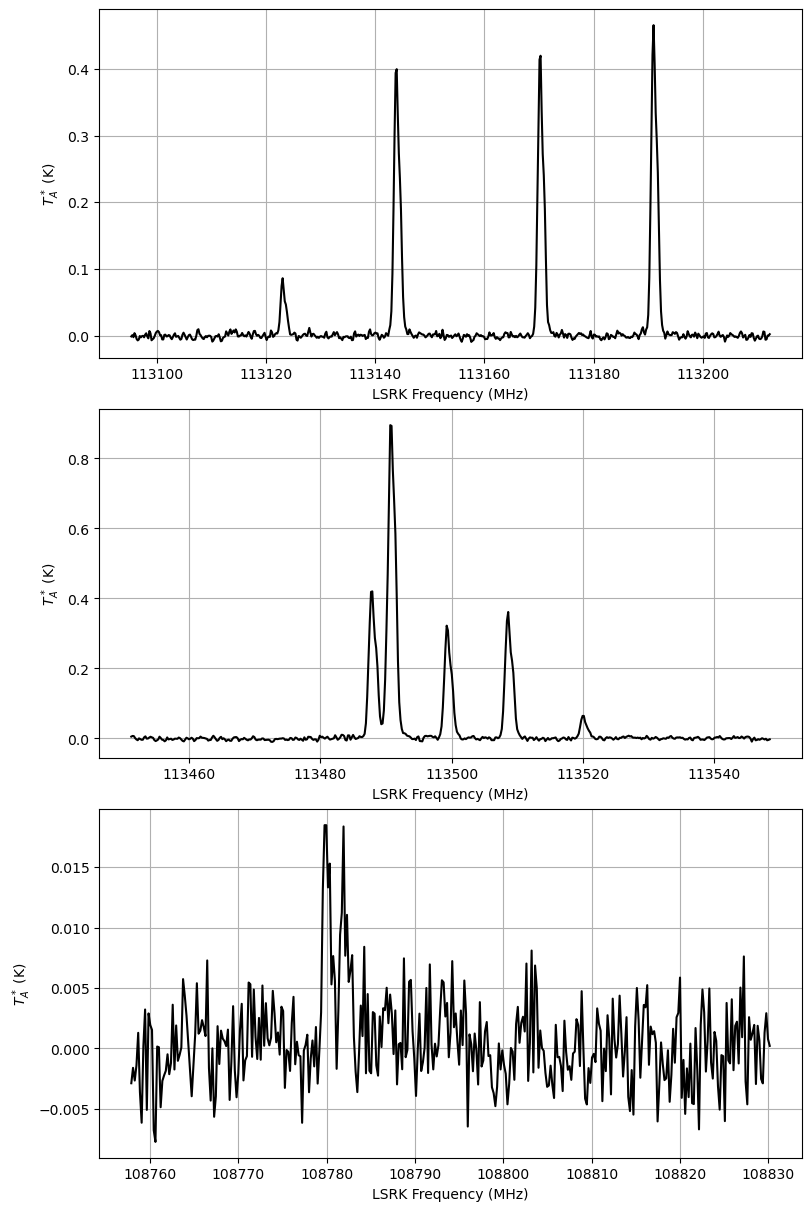

In [2]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("12CN_13CN_spectra/12CN_G211.59_freq.dat")
data_13CN = np.genfromtxt("12CN_13CN_spectra/13CN_G211.59_freq.dat")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 1] - np.median(data_12CN[:, 1])))
print("rms 12CN", noise_12CN)
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 1] - np.median(data_13CN[:, 1])))
print("rms 13CN", noise_13CN)

obs_12CN_1 = SpecData(
    data_12CN[0:600, 0],
    data_12CN[0:600, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
obs_12CN_2 = SpecData(
    data_12CN[-500:-1, 0],
    data_12CN[-500:-1, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
obs_13CN = SpecData(
    data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
data = {"12CN-1": obs_12CN_1, "12CN-2": obs_12CN_2, "13CN": obs_13CN}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in data.keys() if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(len(data), layout="constrained", figsize=(8, 12))
for i, label in enumerate(data.keys()):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Reproduce Sun et al. (2024) model

In [3]:
import astropy.units as u
import astropy.constants as c
from bayes_cn_hfs.utils import supplement_mol_data
from bayes_cn_hfs.physics import calc_stat_weight

mol_data_12CN, weight_12CN = supplement_mol_data("CN")
print(mol_data_12CN)

sun2024_tau_ml = 0.86
sun2024_Tex = 4.61*u.K
freq = 113.5*u.GHz

# main line upper state column density
sun2024_Nu_ml = 8.0*np.pi*freq**2.0 / c.c**2.0 / (np.exp(c.h*freq/(c.k_B*sun2024_Tex)) - 1.0) / (mol_data_12CN["Aul"][5]/u.s) / (1.0/u.MHz) * sun2024_tau_ml
print("main line log10 upper column density", np.log10(sun2024_Nu_ml.to('cm-2').value))

# partition function
stat_weights = calc_stat_weight(mol_data_12CN["states"]["deg"], mol_data_12CN["states"]["E"], sun2024_Tex.to("K").value).eval()
Qtot = np.sum(stat_weights)

# total column density
sun2024_log10_Ntot = np.log10(Qtot/stat_weights[6] * sun2024_Nu_ml.to('cm-2').value)
print("log10 total column density", sun2024_log10_Ntot)

{'freq': array([113123.3687, 113144.19  , 113170.535 , 113191.325 , 113488.142 ,
       113490.985 , 113499.643 , 113508.934 , 113520.4215]), 'Aul': array([1.26969616e-06, 1.03939111e-05, 5.07869910e-06, 6.59525390e-06,
       6.64784064e-06, 1.17706070e-05, 1.04919208e-05, 5.12459350e-06,
       1.28243028e-06]), 'degu': array([2, 2, 4, 4, 4, 6, 2, 4, 2]), 'El': array([1.3905121e-19, 0.0000000e+00, 1.3905121e-19, 0.0000000e+00,
       1.3905121e-19, 0.0000000e+00, 1.3905121e-19, 0.0000000e+00,
       0.0000000e+00]), 'Eu': array([7.49702428e-16, 7.49701340e-16, 7.50014955e-16, 7.50013660e-16,
       7.52119441e-16, 7.51999228e-16, 7.52195648e-16, 7.52118159e-16,
       7.52194276e-16]), 'relative_int': array([0.01204699, 0.09860036, 0.09633376, 0.1250773 , 0.12574146,
       0.33394774, 0.09921527, 0.09691221, 0.01212491]), 'log10_Q_terms': array([0.40307694, 0.97433601]), 'Qu': ['1 0 1 1', '1 0 1 1', '1 0 1 2', '1 0 1 2', '1 0 2 2', '1 0 2 3', '1 0 2 1', '1 0 2 2', '1 0 2 1'], 'Ql': 


Tex
[[4.61]
 [4.61]
 [4.61]
 [4.61]
 [4.61]
 [4.61]
 [4.61]
 [4.61]
 [4.61]]

tau
[[0.03106518]
 [0.25429057]
 [0.24836437]
 [0.32251198]
 [0.32375786]
 [0.86002019]
 [0.25544636]
 [0.2495611 ]
 [0.03122169]]

tau_total
[2.57623928]

TR
[[2.4163491 ]
 [2.41603698]
 [2.4156421 ]
 [2.41533052]
 [2.41088554]
 [2.410843  ]
 [2.41071344]
 [2.41057441]
 [2.41040252]]


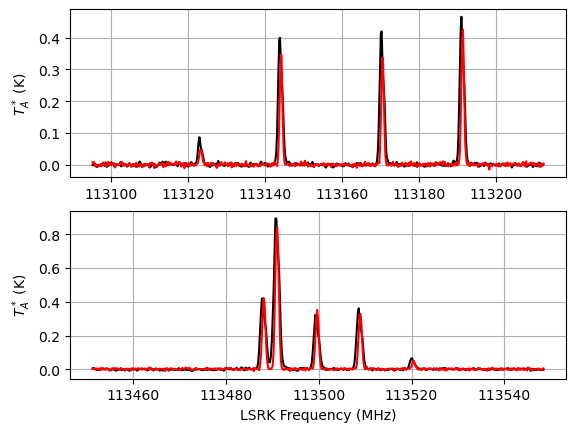

In [6]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = [0.75, 0.25], # ignored because LTE
    assume_CTEX = True, # implied because LTE
    prior_LTE_precision = 100.0, # ignored because LTE
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# Simulate with Sun et al. (2024) parameters
# FWHM is unknown, we pick 2 km/s because it looks good
sim_params = {
    "log10_N": [sun2024_log10_Ntot],
    "log10_Tkin": [np.log10(sun2024_Tex.to("K").value)],
    "fwhm_nonthermal": [2.0],
    "velocity": [0.0],
    "fwhm_L": 0.0,
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

derived_params = ["Tex", "tau", "tau_total", "TR"]
derived_params = {
    param: model.model[param].eval(sim_params, on_unused_input="ignore")
    for param in derived_params
}

for key, value in derived_params.items():
    print()
    print(key)
    print(value)

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(data["12CN-1"].spectral, data["12CN-1"].brightness, "k-")
axes[0].plot(data["12CN-1"].spectral, sim_obs1, "r-")
axes[0].set_ylabel(data["12CN-1"].ylabel)
axes[1].plot(data["12CN-2"].spectral, data["12CN-2"].brightness, "k-")
axes[1].plot(data["12CN-2"].spectral, sim_obs2, "r-")
axes[1].set_xlabel(data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(data["12CN-2"].ylabel)

This simulation is consistent with the Sun et al. (2024) model. Note the failure to fit the other lines. This is not a great model.

## Ratio Model
We fix the kinetic temperature at the Sun et al. (2024) model value and assume LTE.

In [4]:
from bayes_cn_hfs import CNRatioModel

# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.8, 0.2], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = np.log10(sun2024_Tex.to("K").value), # fix the kinetic (excitation) temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, ratio_12C_13C, velocity_norm]


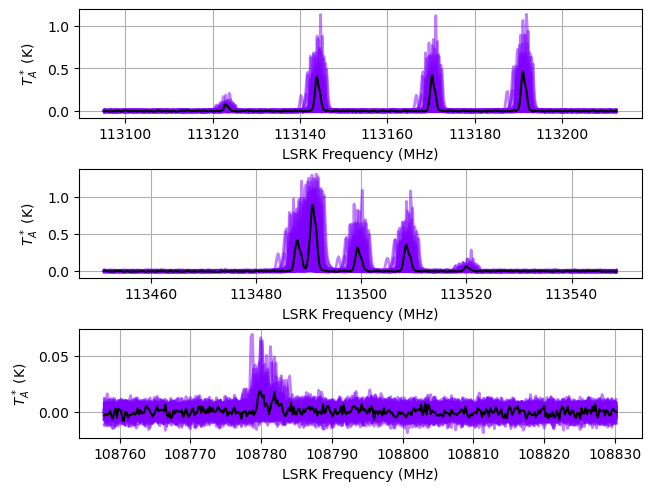

In [5]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [6]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 4400
Interrupted at 4,399 [4%]: Average Loss = 16,071


Output()

Runtime: 1.21 minutes


Sampling: [12CN-1, 12CN-2, 13CN]


Output()

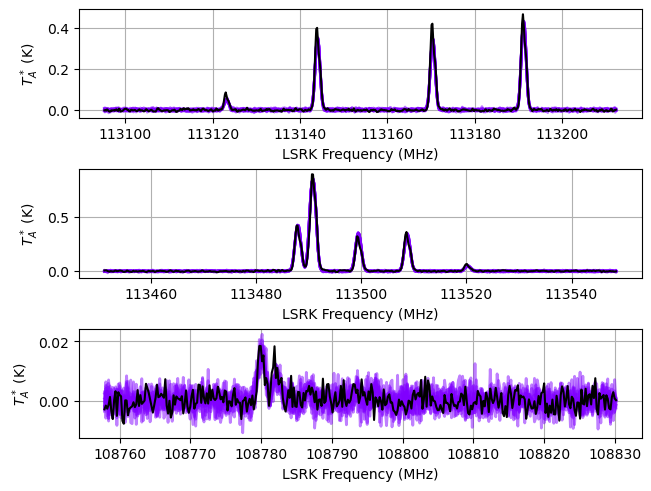

In [7]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [8]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4400
Interrupted at 4,399 [4%]: Average Loss = 16,071
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.


Adding log-likelihood to trace


Output()

There were 6 divergences in converged chains.
Runtime: 2.03 minutes


In [9]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [11]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs + ["ratio_12C_13C"])

solutions: [0]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
velocity[0]              4.510000e-01  3.000000e-03  4.450000e-01   
fwhm_thermal_12CN[0]     9.000000e-02  0.000000e+00  9.000000e-02   
fwhm_thermal_13CN[0]     8.800000e-02  0.000000e+00  8.800000e-02   
fwhm_nonthermal[0]       3.186000e+00  6.000000e-03  3.174000e+00   
fwhm_12CN[0]             3.188000e+00  6.000000e-03  3.176000e+00   
fwhm_13CN[0]             3.187000e+00  6.000000e-03  3.176000e+00   
log10_N_12CN[0]          1.406600e+01  1.000000e-03  1.406400e+01   
N_13CN[0]                2.657459e+12  1.902996e+11  2.297188e+12   
log10_Tex_ul[0]          6.640000e-01  0.000000e+00  6.640000e-01   
tau_total_12CN[0]        4.108000e+00  8.000000e-03  4.093000e+00   
tau_total_13CN[0]        8.600000e-02  6.000000e-03  7.400000e-02   
fwhm_L                   4.000000e-03  4.000000e-03  0.000000e+00   
baseline_12CN-1_norm[0]  2.810000e-01  4.100000e-02  2.000000e-01   
baseline_12CN-2_norm[0] -5.490000e-01  4.700000e-02 -6.360000e-01   
baseline_13CN_norm[0]   -8.000000e-02  5.400000e-02 -1.810000e-01   
ratio_12C_13C[0]         4.399200e+01  3.197000e+00  3.827300e+01   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]              4.560000e-01  0.000000e+00  0.000000e+00   10965.0   
fwhm_thermal_12CN[0]     9.000000e-02  0.000000e+00  0.000000e+00    8000.0   
fwhm_thermal_13CN[0]     8.800000e-02  0.000000e+00  0.000000e+00    8000.0   
fwhm_nonthermal[0]       3.198000e+00  0.000000e+00  0.000000e+00    9954.0   
fwhm_12CN[0]             3.200000e+00  0.000000e+00  0.000000e+00    9954.0   
fwhm_13CN[0]             3.200000e+00  0.000000e+00  0.000000e+00    9954.0   
log10_N_12CN[0]          1.406700e+01  0.000000e+00  0.000000e+00    9099.0   
N_13CN[0]                3.010696e+12  1.886543e+09  1.334026e+09   10149.0   
log10_Tex_ul[0]          6.640000e-01  0.000000e+00  0.000000e+00    8000.0   
tau_total_12CN[0]        4.123000e+00  0.000000e+00  0.000000e+00    9099.0   
tau_total_13CN[0]        9.700000e-02  0.000000e+00  0.000000e+00   10149.0   
fwhm_L                   1.200000e-02  0.000000e+00  0.000000e+00    5273.0   
baseline_12CN-1_norm[0]  3.550000e-01  0.000000e+00  0.000000e+00   10517.0   
baseline_12CN-2_norm[0] -4.600000e-01  0.000000e+00  0.000000e+00    9886.0   
baseline_13CN_norm[0]    2.400000e-02  1.000000e-03  0.000000e+00   10441.0   
ratio_12C_13C[0]         5.012900e+01  3.200000e-02  2.300000e-02   10168.0   

                         ess_tail  r_hat  
velocity[0]                5309.0    1.0  
fwhm_thermal_12CN[0]       8000.0    NaN  
fwhm_thermal_13CN[0]       8000.0    NaN  
fwhm_nonthermal[0]         5803.0    1.0  
fwhm_12CN[0]               5803.0    1.0  
fwhm_13CN[0]               5803.0    1.0  
log10_N_12CN[0]            5913.0    1.0  
N_13CN[0]                  6100.0    1.0  
log10_Tex_ul[0]            8000.0    NaN  
tau_total_12CN[0]          5913.0    1.0  
tau_total_13CN[0]          6100.0    1.0  
fwhm_L                     3600.0    1.0  
baseline_12CN-1_norm[0]    6443.0    1.0  
baseline_12CN-2_norm[0]    5996.0    1.0  
baseline_13CN_norm[0]      6039.0    1.0  
ratio_12C_13C[0]           6076.0    1.0

Because we find more $^{12}{\rm CN}$ when considering more transitions, we find a slightly smaller $^{12}{\rm C}/^{13}{\rm C}$ ratio: $44.0 \pm 3.2$ compared to Sun et al. (2024) who found $52.2 \pm 6.7$.

## Single component LTE
Mimic Sun et al. (2024) analysis.

In [7]:
# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = [0.75, 0.25], # ignored because LTE
    assume_CTEX = True, # implied because LTE
    prior_LTE_precision = 100.0, # ignored because LTE
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tkin_norm, velocity_norm]


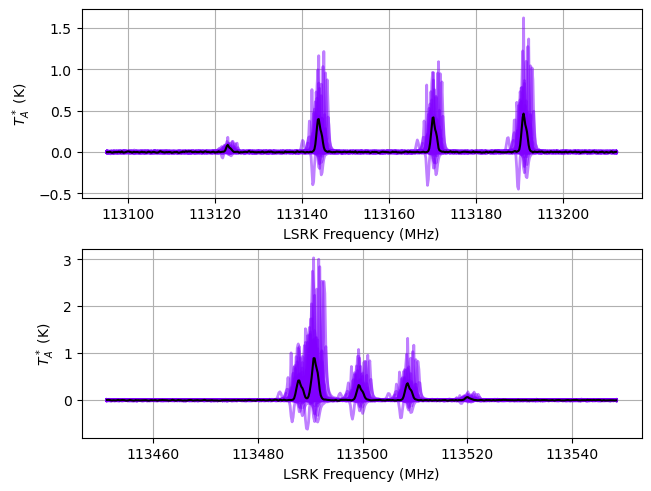

In [8]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [9]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 4900
Interrupted at 4,899 [4%]: Average Loss = 21,450


Output()

Runtime: 0.61 minutes


Sampling: [12CN-1, 12CN-2]


Output()

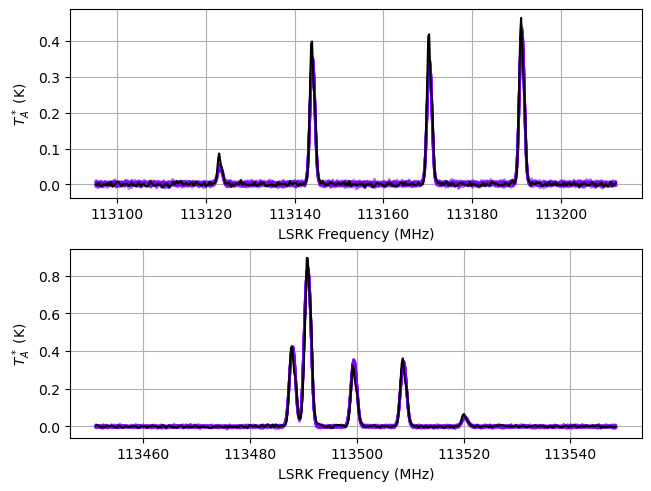

In [10]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [11]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics + model.hyper_freeRVs + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               0.458  0.004   0.451    0.465      0.000    0.000   
log10_Tkin[0]             0.659  0.000   0.658    0.660      0.000    0.000   
fwhm_thermal[0]           0.090  0.000   0.090    0.090      0.000    0.000   
fwhm_nonthermal[0]        3.186  0.007   3.173    3.198      0.000    0.000   
fwhm[0]                   3.187  0.007   3.175    3.199      0.000    0.000   
log10_N[0]               14.075  0.001  14.073   14.077      0.000    0.000   
log10_Tex_ul[0]           0.659  0.000   0.658    0.660      0.000    0.000   
Tex[113123.3687, 0]       4.559  0.004   4.551    4.567      0.000    0.000   
Tex[113144.19, 0]         4.559  0.004   4.551    4.567      0.000    0.000   
Tex[113170.535, 0]        4.559  0.004   4.551    4.567      0.000    0.000   
Tex[113191.325, 0]        4.559  0.004   4.551    4.567      0.000    0.000   
Tex[113488.142, 0]        4.559  0.004   4.551    4.567      0.000    0.000   
Tex[113490.985, 0]        4.559  0.004   4.551    4.567      0.000    0.000   
Tex[113499.643, 0]        4.559  0.004   4.551    4.567      0.000    0.000   
Tex[113508.934, 0]        4.559  0.004   4.551    4.567      0.000    0.000   
Tex[113520.4215, 0]       4.559  0.004   4.551    4.567      0.000    0.000   
tau[113123.3687, 0]       0.051  0.000   0.051    0.051      0.000    0.000   
tau[113144.19, 0]         0.419  0.001   0.418    0.421      0.000    0.000   
tau[113170.535, 0]        0.410  0.001   0.408    0.411      0.000    0.000   
tau[113191.325, 0]        0.532  0.001   0.530    0.534      0.000    0.000   
tau[113488.142, 0]        0.534  0.001   0.532    0.536      0.000    0.000   
tau[113490.985, 0]        1.419  0.003   1.412    1.425      0.000    0.000   
tau[113499.643, 0]        0.421  0.001   0.419    0.423      0.000    0.000   
tau[113508.934, 0]        0.412  0.001   0.410    0.413      0.000    0.000   
tau[113520.4215, 0]       0.052  0.000   0.051    0.052      0.000    0.000   
tau_total[0]              4.250  0.010   4.231    4.268      0.000    0.000   
TR[113123.3687, 0]        2.371  0.004   2.363    2.378      0.000    0.000   
TR[113144.19, 0]          2.371  0.004   2.363    2.377      0.000    0.000   
TR[113170.535, 0]         2.370  0.004   2.363    2.377      0.000    0.000   
TR[113191.325, 0]         2.370  0.004   2.362    2.377      0.000    0.000   
TR[113488.142, 0]         2.365  0.004   2.358    2.372      0.000    0.000   
TR[113490.985, 0]         2.365  0.004   2.358    2.372      0.000    0.000   
TR[113499.643, 0]         2.365  0.004   2.358    2.372      0.000    0.000   
TR[113508.934, 0]         2.365  0.004   2.358    2.372      0.000    0.000   
TR[113520.4215, 0]        2.365  0.004   2.357    2.372      0.000    0.000   
fwhm_L_norm               0.007  0.004   0.001    0.014      0.000    0.000   
baseline_12CN-1_norm[0]   0.265  0.044   0.190    0.355      0.001    0.001   
baseline_12CN-2_norm[0]  -0.553  0.048  -0.632   -0.454      0.002    0.001   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                 987.0     925.0    NaN  
log10_Tkin[0]               980.0     944.0    NaN  
fwhm_thermal[0]             980.0     944.0    NaN  
fwhm_nonthermal[0]          958.0     875.0    NaN  
fwhm[0]                     957.0     875.0    NaN  
log10_N[0]                  972.0     935.0    NaN  
log10_Tex_ul[0]             980.0     944.0    NaN  
Tex[113123.3687, 0]         980.0     944.0    NaN  
Tex[113144.19, 0]           980.0     944.0    NaN  
Tex[113170.535, 0]          980.0     944.0    NaN  
Tex[113191.325, 0]          980.0     944.0    NaN  
Tex[113488.142, 0]          980.0     944.0    NaN  
Tex[113490.985, 0]          980.0     944.0    NaN  
Tex[113499.643, 0]          980.0     944.0    NaN  
Tex[113508.934, 0]          980.0     944.0    NaN  
Tex[113520.4215, 0]         980.0     944.0    NaN  
tau[113123.3687, 0]         947.0    1021.0 

In [12]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4900
Interrupted at 4,899 [4%]: Average Loss = 21,450
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


Adding log-likelihood to trace


Output()

Runtime: 2.49 minutes


In [13]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

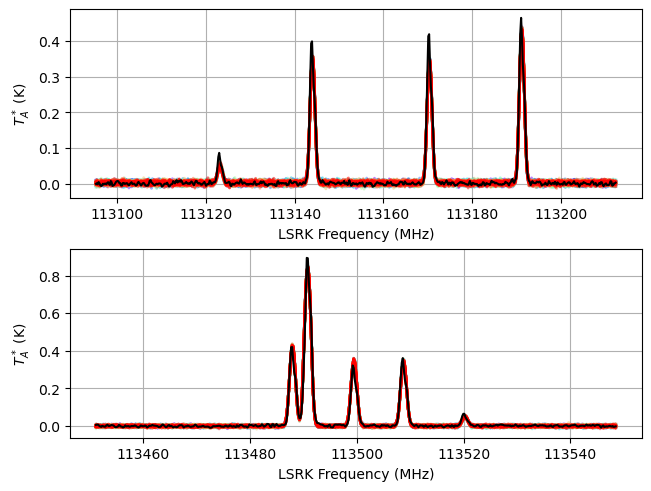

In [14]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [15]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics + model.hyper_freeRVs + model.baseline_freeRVs)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               0.451  0.003   0.446    0.456      0.000    0.000   
log10_Tkin[0]             0.659  0.001   0.657    0.662      0.000    0.000   
fwhm_thermal[0]           0.090  0.000   0.089    0.090      0.000    0.000   
fwhm_nonthermal[0]        3.179  0.007   3.167    3.192      0.000    0.000   
fwhm[0]                   3.181  0.007   3.168    3.193      0.000    0.000   
log10_N[0]               14.075  0.003  14.069   14.082      0.000    0.000   
log10_Tex_ul[0]           0.659  0.001   0.657    0.662      0.000    0.000   
Tex[113123.3687, 0]       4.563  0.015   4.536    4.591      0.000    0.000   
Tex[113144.19, 0]         4.563  0.015   4.536    4.591      0.000    0.000   
Tex[113170.535, 0]        4.563  0.015   4.536    4.591      0.000    0.000   
Tex[113191.325, 0]        4.563  0.015   4.536    4.591      0.000    0.000   
Tex[113488.142, 0]        4.563  0.015   4.536    4.591      0.000    0.000   
Tex[113490.985, 0]        4.563  0.015   4.536    4.591      0.000    0.000   
Tex[113499.643, 0]        4.563  0.015   4.536    4.591      0.000    0.000   
Tex[113508.934, 0]        4.563  0.015   4.536    4.591      0.000    0.000   
Tex[113520.4215, 0]       4.563  0.015   4.536    4.591      0.000    0.000   
tau[113123.3687, 0]       0.051  0.001   0.050    0.052      0.000    0.000   
tau[113144.19, 0]         0.419  0.005   0.411    0.428      0.000    0.000   
tau[113170.535, 0]        0.410  0.005   0.401    0.418      0.000    0.000   
tau[113191.325, 0]        0.532  0.006   0.521    0.543      0.000    0.000   
tau[113488.142, 0]        0.534  0.006   0.523    0.545      0.000    0.000   
tau[113490.985, 0]        1.418  0.016   1.390    1.449      0.000    0.000   
tau[113499.643, 0]        0.421  0.005   0.413    0.430      0.000    0.000   
tau[113508.934, 0]        0.412  0.005   0.403    0.420      0.000    0.000   
tau[113520.4215, 0]       0.051  0.001   0.050    0.053      0.000    0.000   
tau_total[0]              4.249  0.047   4.163    4.340      0.001    0.001   
TR[113123.3687, 0]        2.375  0.013   2.350    2.400      0.000    0.000   
TR[113144.19, 0]          2.374  0.013   2.350    2.400      0.000    0.000   
TR[113170.535, 0]         2.374  0.013   2.350    2.399      0.000    0.000   
TR[113191.325, 0]         2.374  0.013   2.349    2.399      0.000    0.000   
TR[113488.142, 0]         2.369  0.013   2.345    2.394      0.000    0.000   
TR[113490.985, 0]         2.369  0.013   2.345    2.394      0.000    0.000   
TR[113499.643, 0]         2.369  0.013   2.345    2.394      0.000    0.000   
TR[113508.934, 0]         2.369  0.013   2.345    2.394      0.000    0.000   
TR[113520.4215, 0]        2.369  0.013   2.345    2.394      0.000    0.000   
fwhm_L_norm               0.005  0.004   0.000    0.012      0.000    0.000   
baseline_12CN-1_norm[0]   0.271  0.042   0.197    0.355      0.001    0.000   
baseline_12CN-2_norm[0]  -0.548  0.047  -0.634   -0.459      0.001    0.000   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                7391.0    5771.0    1.0  
log10_Tkin[0]              4152.0    4572.0    1.0  
fwhm_thermal[0]            4152.0    4572.0    1.0  
fwhm_nonthermal[0]         6464.0    5655.0    1.0  
fwhm[0]                    6461.0    5655.0    1.0  
log10_N[0]                 4190.0    4385.0    1.0  
log10_Tex_ul[0]            4152.0    4572.0    1.0  
Tex[113123.3687, 0]        4152.0    4572.0    1.0  
Tex[113144.19, 0]          4152.0    4572.0    1.0  
Tex[113170.535, 0]         4152.0    4572.0    1.0  
Tex[113191.325, 0]         4152.0    4572.0    1.0  
Tex[113488.142, 0]         4152.0    4572.0    1.0  
Tex[113490.985, 0]         4152.0    4572.0    1.0  
Tex[113499.643, 0]         4152.0    4572.0    1.0  
Tex[113508.934, 0]         4152.0    4572.0    1.0  
Tex[113520.4215, 0]        4152.0    4572.0    1.0  
tau[113123.3687, 0]        4150.0    4288.0 

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


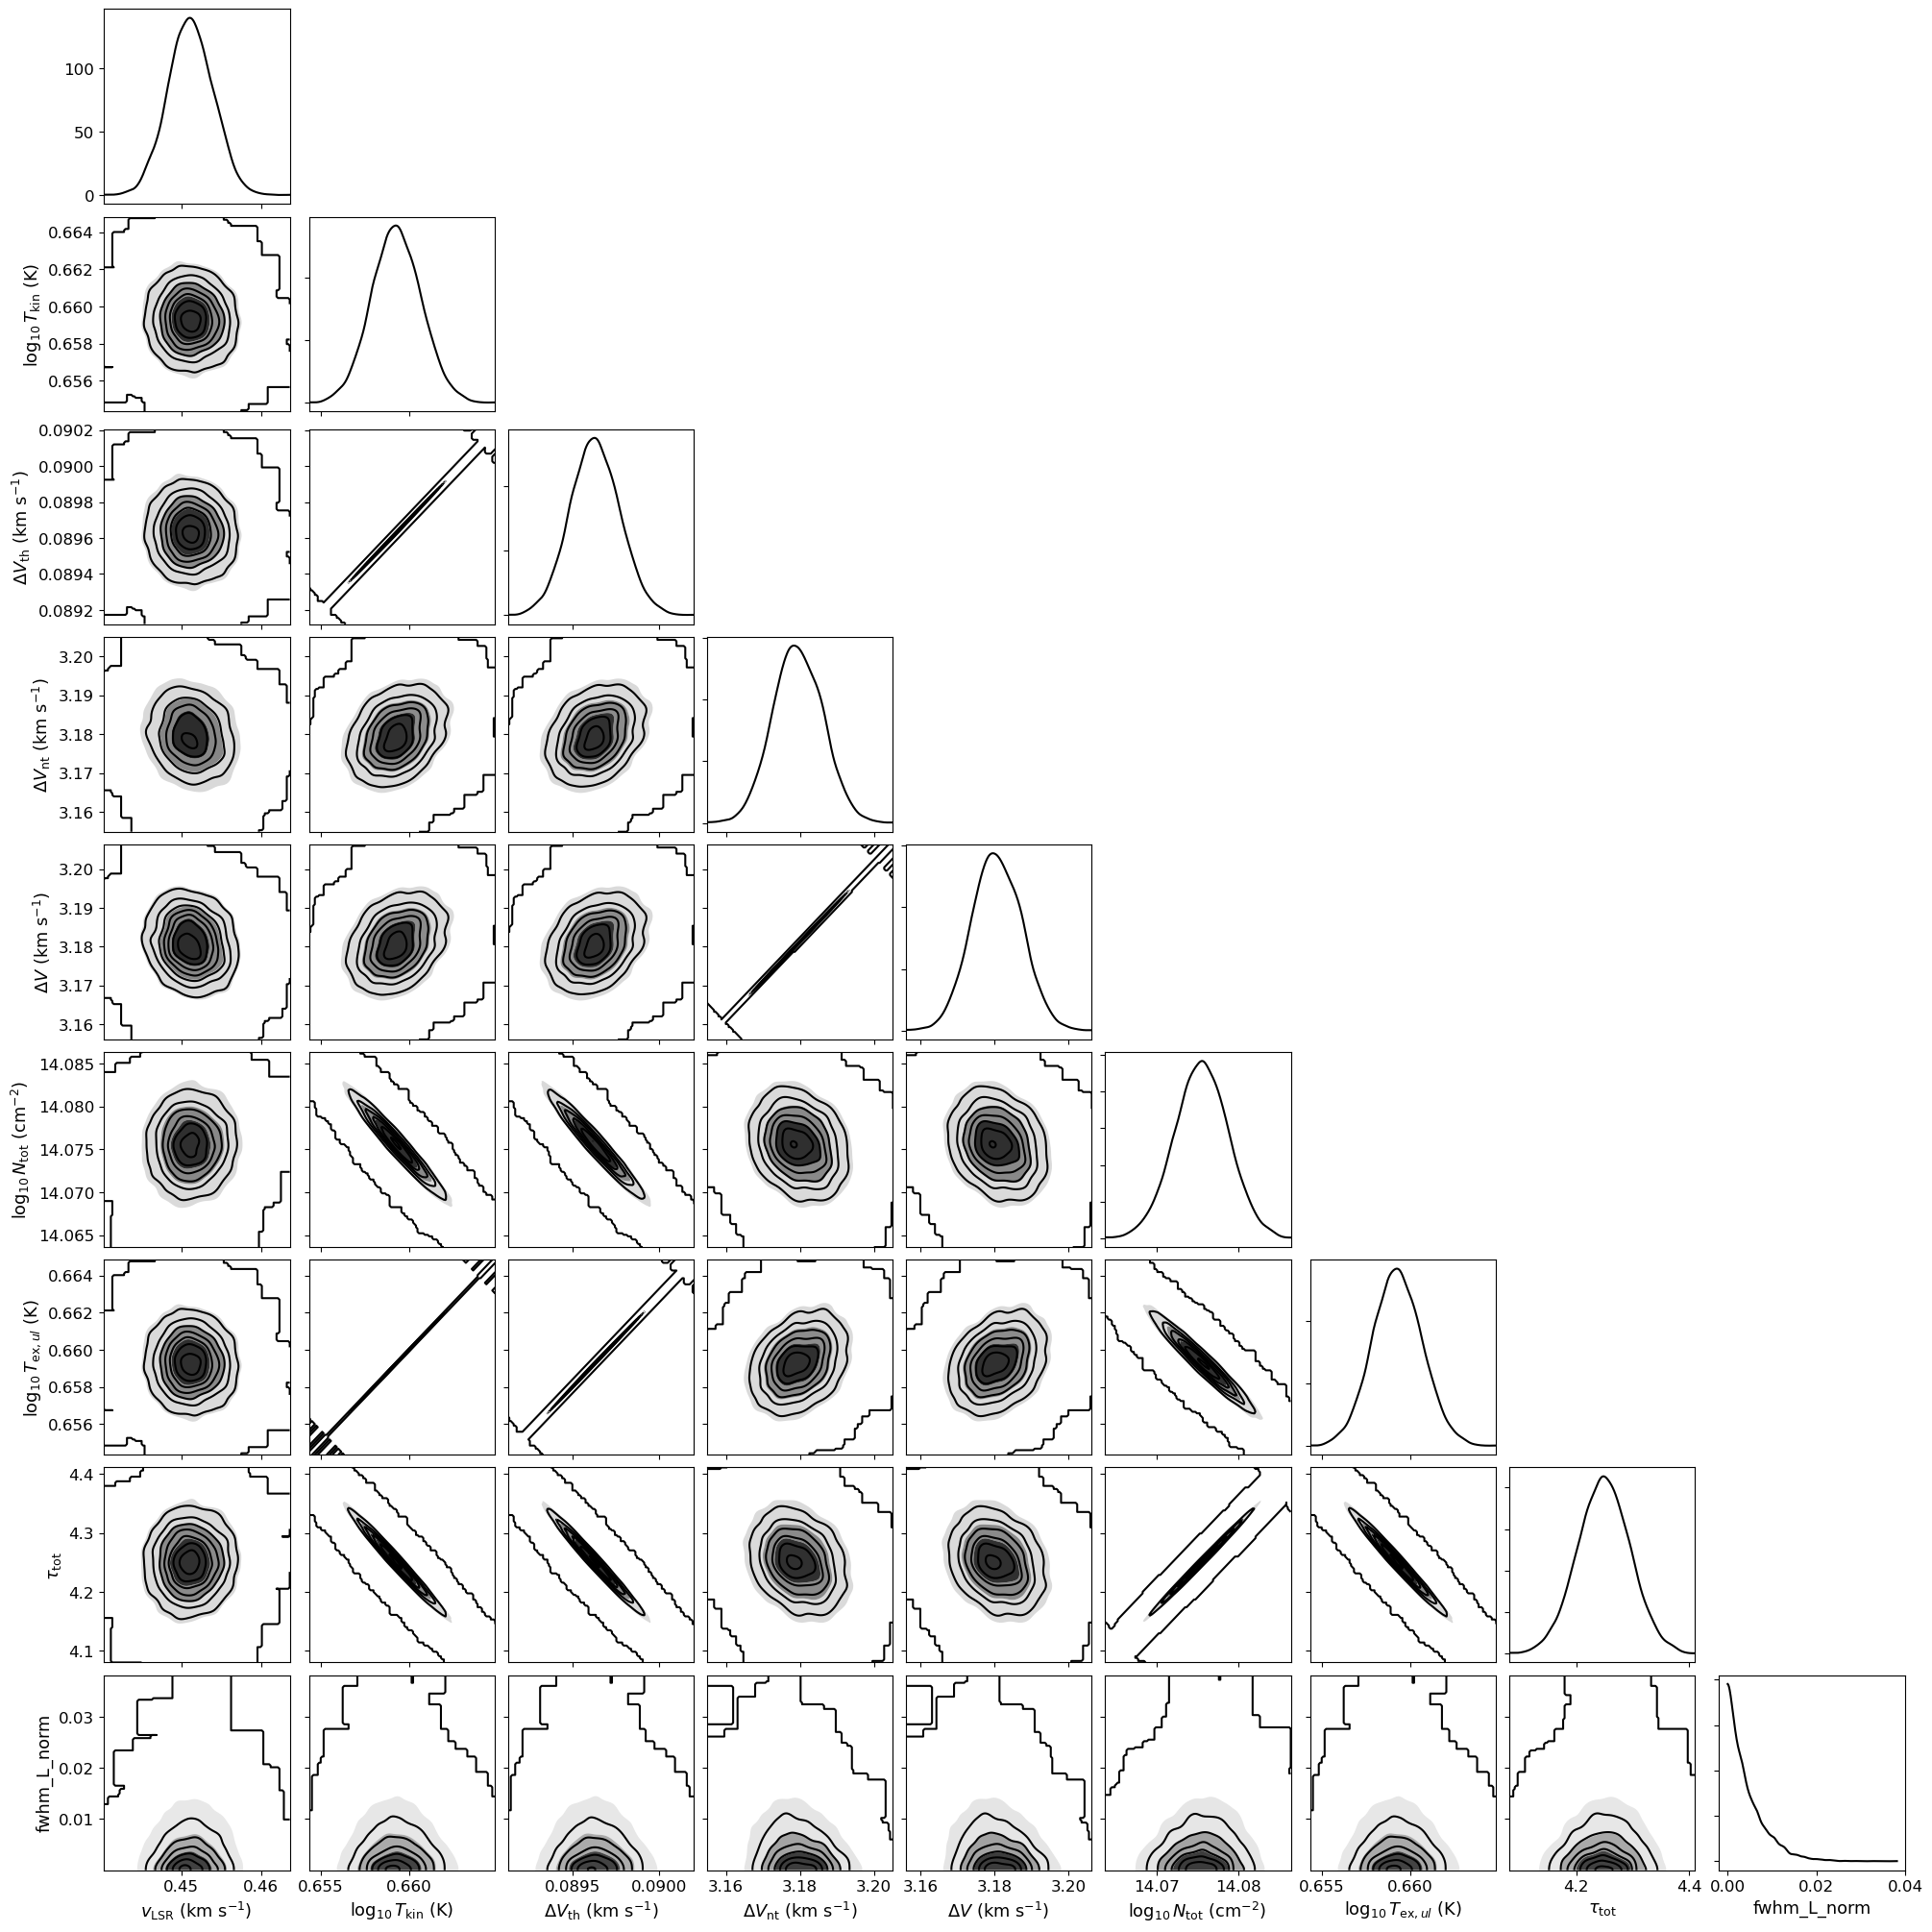

In [16]:
from bayes_spec.plots import plot_pair

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

We find a higher column density and optical depth, but a similar excitation temperature.

## Non-LTE model
Fix the kinetic temperature

In [17]:
# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.75, 0.25], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


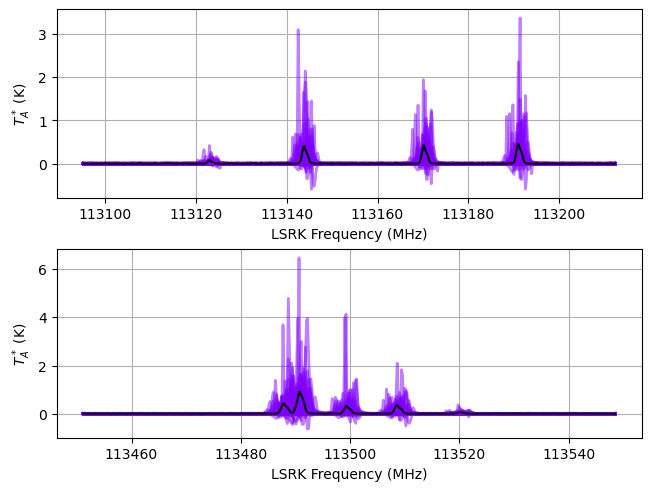

In [18]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [20]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 7300
Interrupted at 7,299 [7%]: Average Loss = 57,774


Output()

Runtime: 0.88 minutes


Sampling: [12CN-1, 12CN-2]


Output()

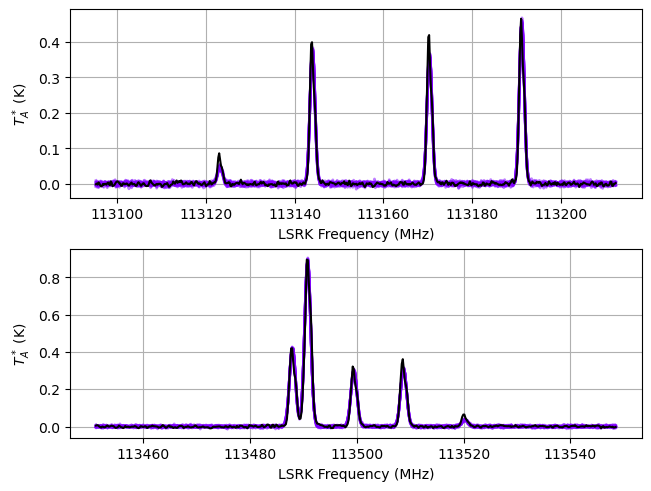

In [21]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [22]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7300
Interrupted at 7,299 [7%]: Average Loss = 57,774
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 379 seconds.


Adding log-likelihood to trace


Output()

Runtime: 7.55 minutes


In [23]:
model.solve()

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

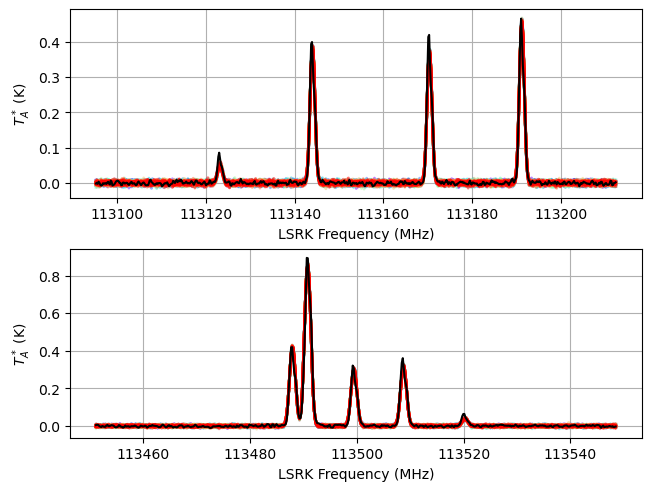

In [24]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [25]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    # if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "transition_free", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               0.455  0.003   0.449    0.460      0.000    0.000   
fwhm_thermal[0]           0.236  0.000   0.236    0.236      0.000    0.000   
fwhm_nonthermal[0]        3.296  0.012   3.273    3.318      0.000    0.000   
fwhm[0]                   3.304  0.012   3.282    3.326      0.000    0.000   
log10_N[0]               13.916  0.015  13.888   13.943      0.000    0.000   
log10_Tex_ul[0]           0.767  0.038   0.701    0.839      0.001    0.001   
Tex[113123.3687, 0]       6.805  0.303   6.265    7.389      0.009    0.006   
Tex[113144.19, 0]         6.263  0.224   5.870    6.698      0.006    0.005   
Tex[113170.535, 0]        6.562  0.271   6.077    7.084      0.008    0.005   
Tex[113191.325, 0]        6.057  0.202   5.698    6.450      0.006    0.004   
Tex[113488.142, 0]        6.010  0.218   5.621    6.432      0.006    0.004   
Tex[113490.985, 0]        5.414  0.123   5.188    5.646      0.004    0.002   
Tex[113499.643, 0]        5.551  0.181   5.222    5.896      0.005    0.004   
Tex[113508.934, 0]        5.586  0.165   5.295    5.908      0.005    0.003   
Tex[113520.4215, 0]       5.188  0.140   4.934    5.455      0.004    0.003   
tau[113123.3687, 0]       0.024  0.002   0.020    0.027      0.000    0.000   
tau[113144.19, 0]         0.219  0.015   0.190    0.247      0.000    0.000   
tau[113170.535, 0]        0.194  0.015   0.164    0.221      0.000    0.000   
tau[113191.325, 0]        0.283  0.019   0.247    0.319      0.001    0.000   
tau[113488.142, 0]        0.267  0.020   0.229    0.303      0.001    0.000   
tau[113490.985, 0]        0.807  0.049   0.715    0.899      0.001    0.001   
tau[113499.643, 0]        0.221  0.016   0.191    0.250      0.000    0.000   
tau[113508.934, 0]        0.230  0.015   0.202    0.257      0.000    0.000   
tau[113520.4215, 0]       0.030  0.002   0.027    0.034      0.000    0.000   
tau_total[0]              2.273  0.152   1.987    2.556      0.004    0.003   
TR[113123.3687, 0]        4.448  0.287   3.938    5.004      0.008    0.006   
TR[113144.19, 0]          3.936  0.211   3.568    4.346      0.006    0.004   
TR[113170.535, 0]         4.217  0.257   3.756    4.708      0.007    0.005   
TR[113191.325, 0]         3.742  0.190   3.407    4.110      0.005    0.004   
TR[113488.142, 0]         3.693  0.204   3.331    4.089      0.006    0.004   
TR[113490.985, 0]         3.140  0.113   2.933    3.354      0.003    0.002   
TR[113499.643, 0]         3.267  0.168   2.964    3.586      0.005    0.003   
TR[113508.934, 0]         3.298  0.153   3.030    3.597      0.004    0.003   
TR[113520.4215, 0]        2.932  0.128   2.701    3.177      0.004    0.003   
fwhm_L                    0.004  0.004   0.000    0.011      0.000    0.000   
baseline_12CN-1_norm[0]  -0.034  0.042  -0.112    0.045      0.001    0.000   
baseline_12CN-2_norm[0]  -0.237  0.048  -0.329   -0.149      0.001    0.000   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                6171.0    4413.0   1.00  
fwhm_thermal[0]            8000.0    8000.0    NaN  
fwhm_nonthermal[0]         1574.0    2882.0   1.01  
fwhm[0]                    1574.0    2882.0   1.01  
log10_N[0]                 1219.0    2000.0   1.01  
log10_Tex_ul[0]            2886.0    2491.0   1.00  
Tex[113123.3687, 0]        1264.0    2163.0   1.01  
Tex[113144.19, 0]          1223.0    2003.0   1.01  
Tex[113170.535, 0]         1249.0    2068.0   1.01  
Tex[113191.325, 0]         1218.0    2017.0   1.01  
Tex[113488.142, 0]         1241.0    1990.0   1.01  
Tex[113490.985, 0]         1219.0    2020.0   1.01  
Tex[113499.643, 0]         1243.0    1946.0   1.01  
Tex[113508.934, 0]         1227.0    2031.0   1.01  
Tex[113520.4215, 0]        1252.0    2215.0   1.01  
tau[113123.3687, 0]        1239.0    2047.0   1.01  
tau[113144.19, 0]          1217.0    1981.0   1.01  
tau[113170.535, 0]         1235.0    1992.0   1.01  
tau[113191.325, 0

This model is both physically consistent and a better match to the data. There appears to be evidence for multiple cloud components.

## Number of clouds

In [26]:
from bayes_spec import Optimize
from bayes_cn_hfs import CNModel

max_n_clouds = 5
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N = [13.5, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.75, 0.25], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


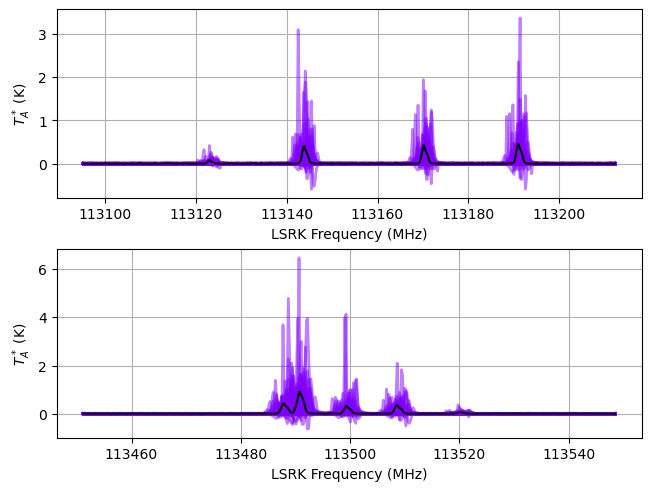

In [27]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

In [28]:
start = time.time()
fit_kwargs = {
    "n": 100_000,
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.01,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 4.940e+05
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 7300
Interrupted at 7,299 [7%]: Average Loss = 57,774


Output()

n_cloud = 1 BIC = -4.668e+02

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 5900
Interrupted at 5,899 [5%]: Average Loss = 76,672


Output()

n_cloud = 2 BIC = -6.201e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 7100
Interrupted at 7,099 [7%]: Average Loss = 1.1911e+05


Output()

n_cloud = 3 BIC = -7.001e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = 5.7003e+05


Output()

n_cloud = 4 BIC = -7.059e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 6700
Interrupted at 6,699 [6%]: Average Loss = 1.9524e+05


Output()

n_cloud = 5 BIC = -6.268e+03

Runtime: 3.91 minutes


[ 4.93955056e+05 -4.66842344e+02 -6.20127260e+03 -7.00061171e+03
 -7.05926265e+03 -6.26757772e+03]


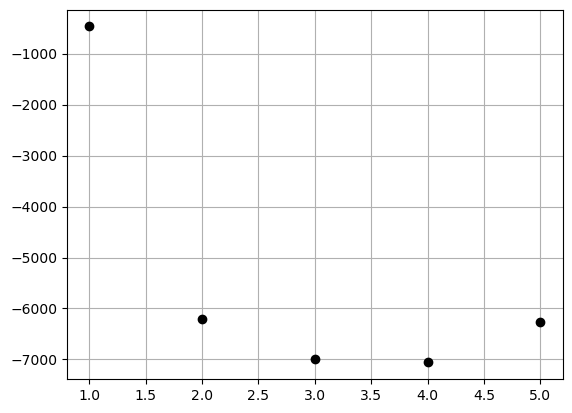

In [29]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko')

In [30]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.01,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 100_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 4.940e+05
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7300
Interrupted at 7,299 [7%]: Average Loss = 57,774
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 380 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -7.731e+02

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5900
Interrupted at 5,899 [5%]: Average Loss = 76,672
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3836 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -6.801e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7100
Interrupted at 7,099 [7%]: Average Loss = 1.1911e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 7658 seconds.


Adding log-likelihood to trace


Output()

There were 13 divergences in converged chains.
GMM converged to unique solution
5 of 8 chains appear converged.
n_cloud = 3 solution = 0 BIC = -8.187e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = 5.7003e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 7972 seconds.


Adding log-likelihood to trace


Output()

There were 1618 divergences in converged chains.
GMM converged to unique solution
6 of 8 chains appear converged.
n_cloud = 4 solution = 0 BIC = -8.820e+03

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6700
Interrupted at 6,699 [6%]: Average Loss = 1.9524e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 10640 seconds.


Adding log-likelihood to trace


Output()

There were 1450 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Runtime: 514.10 minutes


No solutions. Try solve()
[493955.05587382   -773.05805052  -6801.25665558  -8186.93086078
  -8819.68684112             inf]


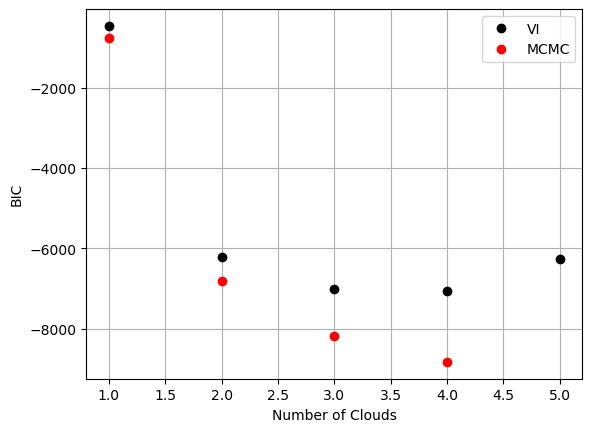

In [32]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_mcmc = np.array([null_bic] + [model.bic() for model in opt.models.values()])
print(bics_mcmc)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
plt.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
plt.xlabel("Number of Clouds")
plt.ylabel("BIC")
_ = plt.legend()

[    0.          -848.09038984 -6936.31486635 -8382.014943
 -9074.79679479            inf]


/tmp/ipykernel_46781/3808025643.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = plt.legend()


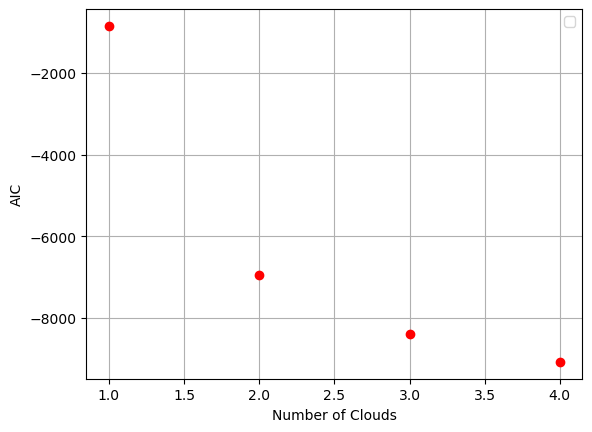

In [36]:
aics_mcmc = np.array([0.0] + [2.0*model._n_params - 2.0*model.mean_lnlike() if len(model.solutions) == 1 else np.inf for model in opt.models.values()])
print(aics_mcmc)

plt.plot(n_clouds[1:], aics_mcmc[1:], 'ro')
plt.xlabel("Number of Clouds")
plt.ylabel("AIC")
_ = plt.legend()

In [47]:
# model = opt.best_model
model = opt.models[4]
print(model.n_clouds)
model.solve()

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
]
pm.summary(model.trace.solution_0, var_names=var_names + ["LTE_precision"] + model.hyper_freeRVs + model.hyper_deterministics + model.baseline_freeRVs)

4
GMM converged to unique solution
6 of 8 chains appear converged.


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean        sd   hdi_3%  hdi_97%  mcse_mean  \
velocity[0]               2.074     0.104    1.857    2.234      0.005   
velocity[1]              -0.985     0.121   -1.210   -0.754      0.003   
velocity[2]              -0.966     0.029   -1.023   -0.912      0.001   
velocity[3]               1.103     0.033    1.036    1.156      0.001   
fwhm_thermal[0]           0.236     0.000    0.236    0.236      0.000   
fwhm_thermal[1]           0.236     0.000    0.236    0.236      0.000   
fwhm_thermal[2]           0.236     0.000    0.236    0.236      0.000   
fwhm_thermal[3]           0.236     0.000    0.236    0.236      0.000   
fwhm_nonthermal[0]        2.245     0.244    1.812    2.673      0.011   
fwhm_nonthermal[1]        3.120     0.359    2.521    3.816      0.012   
fwhm_nonthermal[2]        1.539     0.087    1.384    1.706      0.004   
fwhm_nonthermal[3]        2.064     0.072    1.926    2.186      0.002   
fwhm[0]                   2.258     0.242    1.827    2.684      0.011   
fwhm[1]                   3.130     0.358    2.532    3.823      0.012   
fwhm[2]                   1.557     0.086    1.404    1.722      0.004   
fwhm[3]                   2.078     0.072    1.940    2.199      0.002   
log10_N[0]               13.754     0.099   13.599   13.939      0.004   
log10_N[1]               13.877     0.046   13.791   13.962      0.001   
log10_N[2]               13.338     0.089   13.166   13.501      0.003   
log10_N[3]               14.082     0.114   13.871   14.257      0.006   
log10_Tex_ul[0]           0.434     0.023    0.391    0.477      0.001   
log10_Tex_ul[1]           0.472     0.013    0.449    0.495      0.000   
log10_Tex_ul[2]           0.983     0.172    0.668    1.286      0.005   
log10_Tex_ul[3]           0.797     0.160    0.571    1.117      0.007   
Tex[113123.3687, 0]       2.702     0.096    2.550    2.918      0.003   
Tex[113123.3687, 1]       3.043     0.095    2.870    3.217      0.003   
Tex[113123.3687, 2]       8.782    54.429    3.821   26.040      0.678   
Tex[113123.3687, 3]       7.726    91.370    3.809   16.194      1.183   
Tex[113144.19, 0]         2.777     0.099    2.617    2.983      0.003   
Tex[113144.19, 1]         2.996     0.081    2.853    3.149      0.003   
Tex[113144.19, 2]        -1.842  1035.610    3.949   26.931     13.307   
Tex[113144.19, 3]         5.358    19.258    3.778    9.841      0.292   
Tex[113170.535, 0]        2.722     0.090    2.583    2.923      0.003   
Tex[113170.535, 1]        2.990     0.083    2.837    3.139      0.003   
Tex[113170.535, 2]        7.821   227.760    3.905   35.061      2.916   
Tex[113170.535, 3]        5.992    75.416    3.855   16.587      0.977   
Tex[113191.325, 0]        2.799     0.093    2.647    2.992      0.003   
Tex[113191.325, 1]        2.945     0.075    2.817    3.089      0.003   
Tex[113191.325, 2]        3.274   615.979    4.130   41.285      7.950   
Tex[113191.325, 3]        5.621     8.840    3.817    9.861      0.180   
Tex[113488.142, 0]        2.731     0.082    2.599    2.904      0.003   
Tex[113488.142, 1]        2.996     0.074    2.859    3.131      0.003   
Tex[113488.142, 2]      -10.453  1699.097    3.866   20.865     21.884   
Tex[113488.142, 3]        6.301    45.610    3.728   12.650      0.587   
Tex[113490.985, 0]        2.588     0.087    2.419    2.755      0.002   
Tex[113490.985, 1]        2.926     0.064    2.812    3.040      0.002   
Tex[113490.985, 2]       10.461   554.780 -198.006  206.184      7.267   
Tex[113490.985, 3]        5.150   207.498  -31.376   49.642      2.656   
Tex[113499.643, 0]        2.665     0.075    2.540    2.825      0.003   
Tex[113499.643, 1]        2.974     0.073    2.838    3.105      0.003   
Tex[113499.643, 2]        5.426   124.764    3.592   12.990      1.553   
Tex[113499.643, 3]        5.448    23.867    3.568   10.274      0.336   
Tex[113508.934, 0]        2.808     0.085    2.666    2.979      0.003   
Tex[113508.934, 1]        2.951

Sampling: [12CN-1, 12CN-2]


Output()

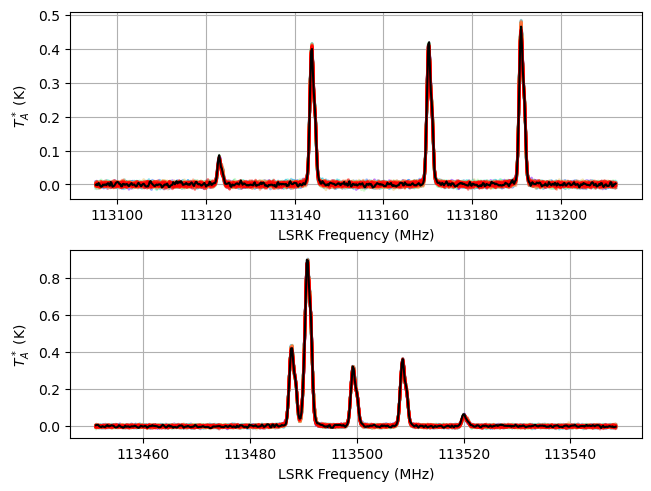

In [46]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

['velocity_norm', 'fwhm_nonthermal_norm', 'log10_N_norm', 'log10_Tex_ul_norm', 'LTE_precision', 'weights']


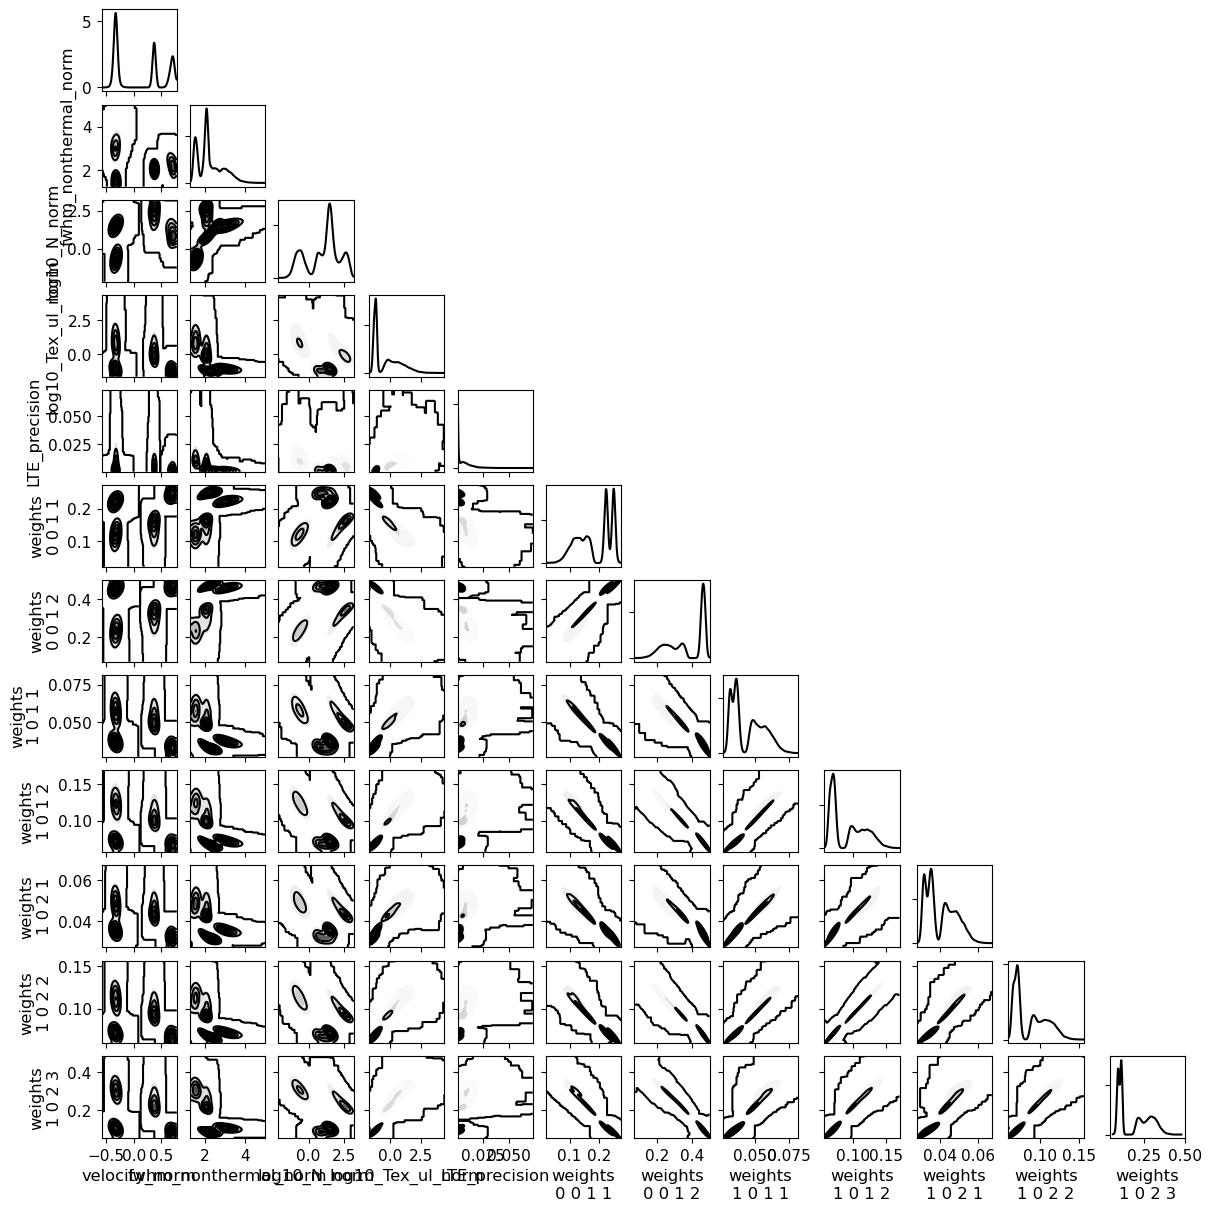

In [40]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
]
print(var_names)
axes = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.set_size_inches(12, 12)

['velocity', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


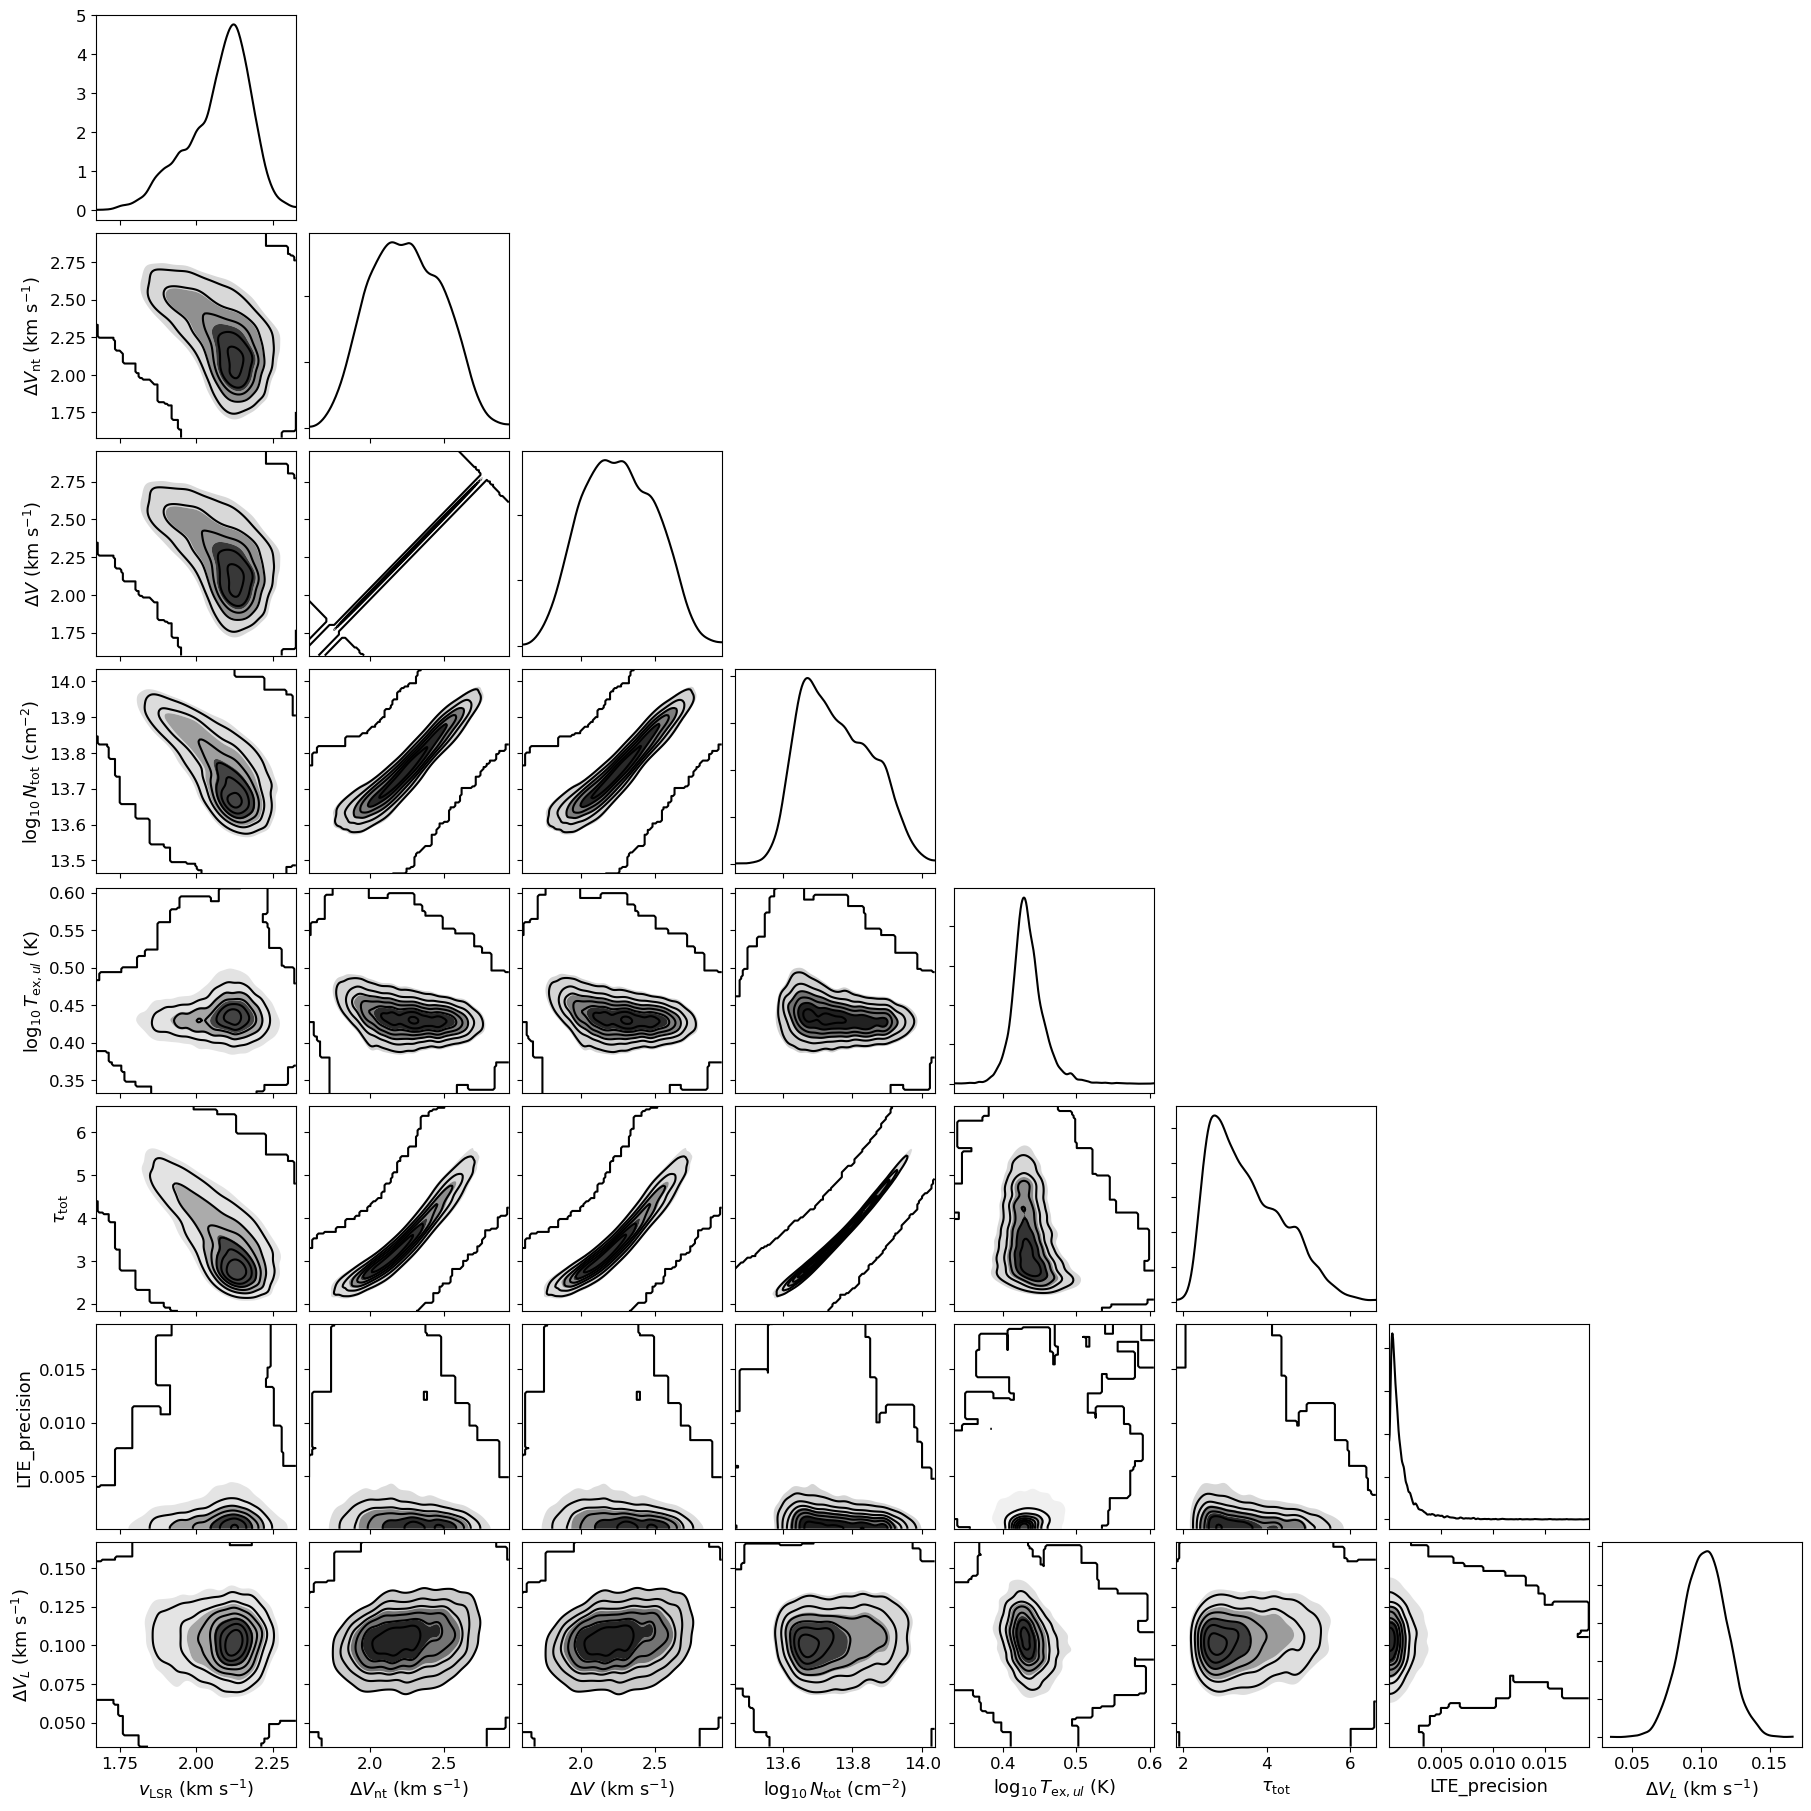

In [41]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
    and param not in ["fwhm_thermal"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + ["LTE_precision"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

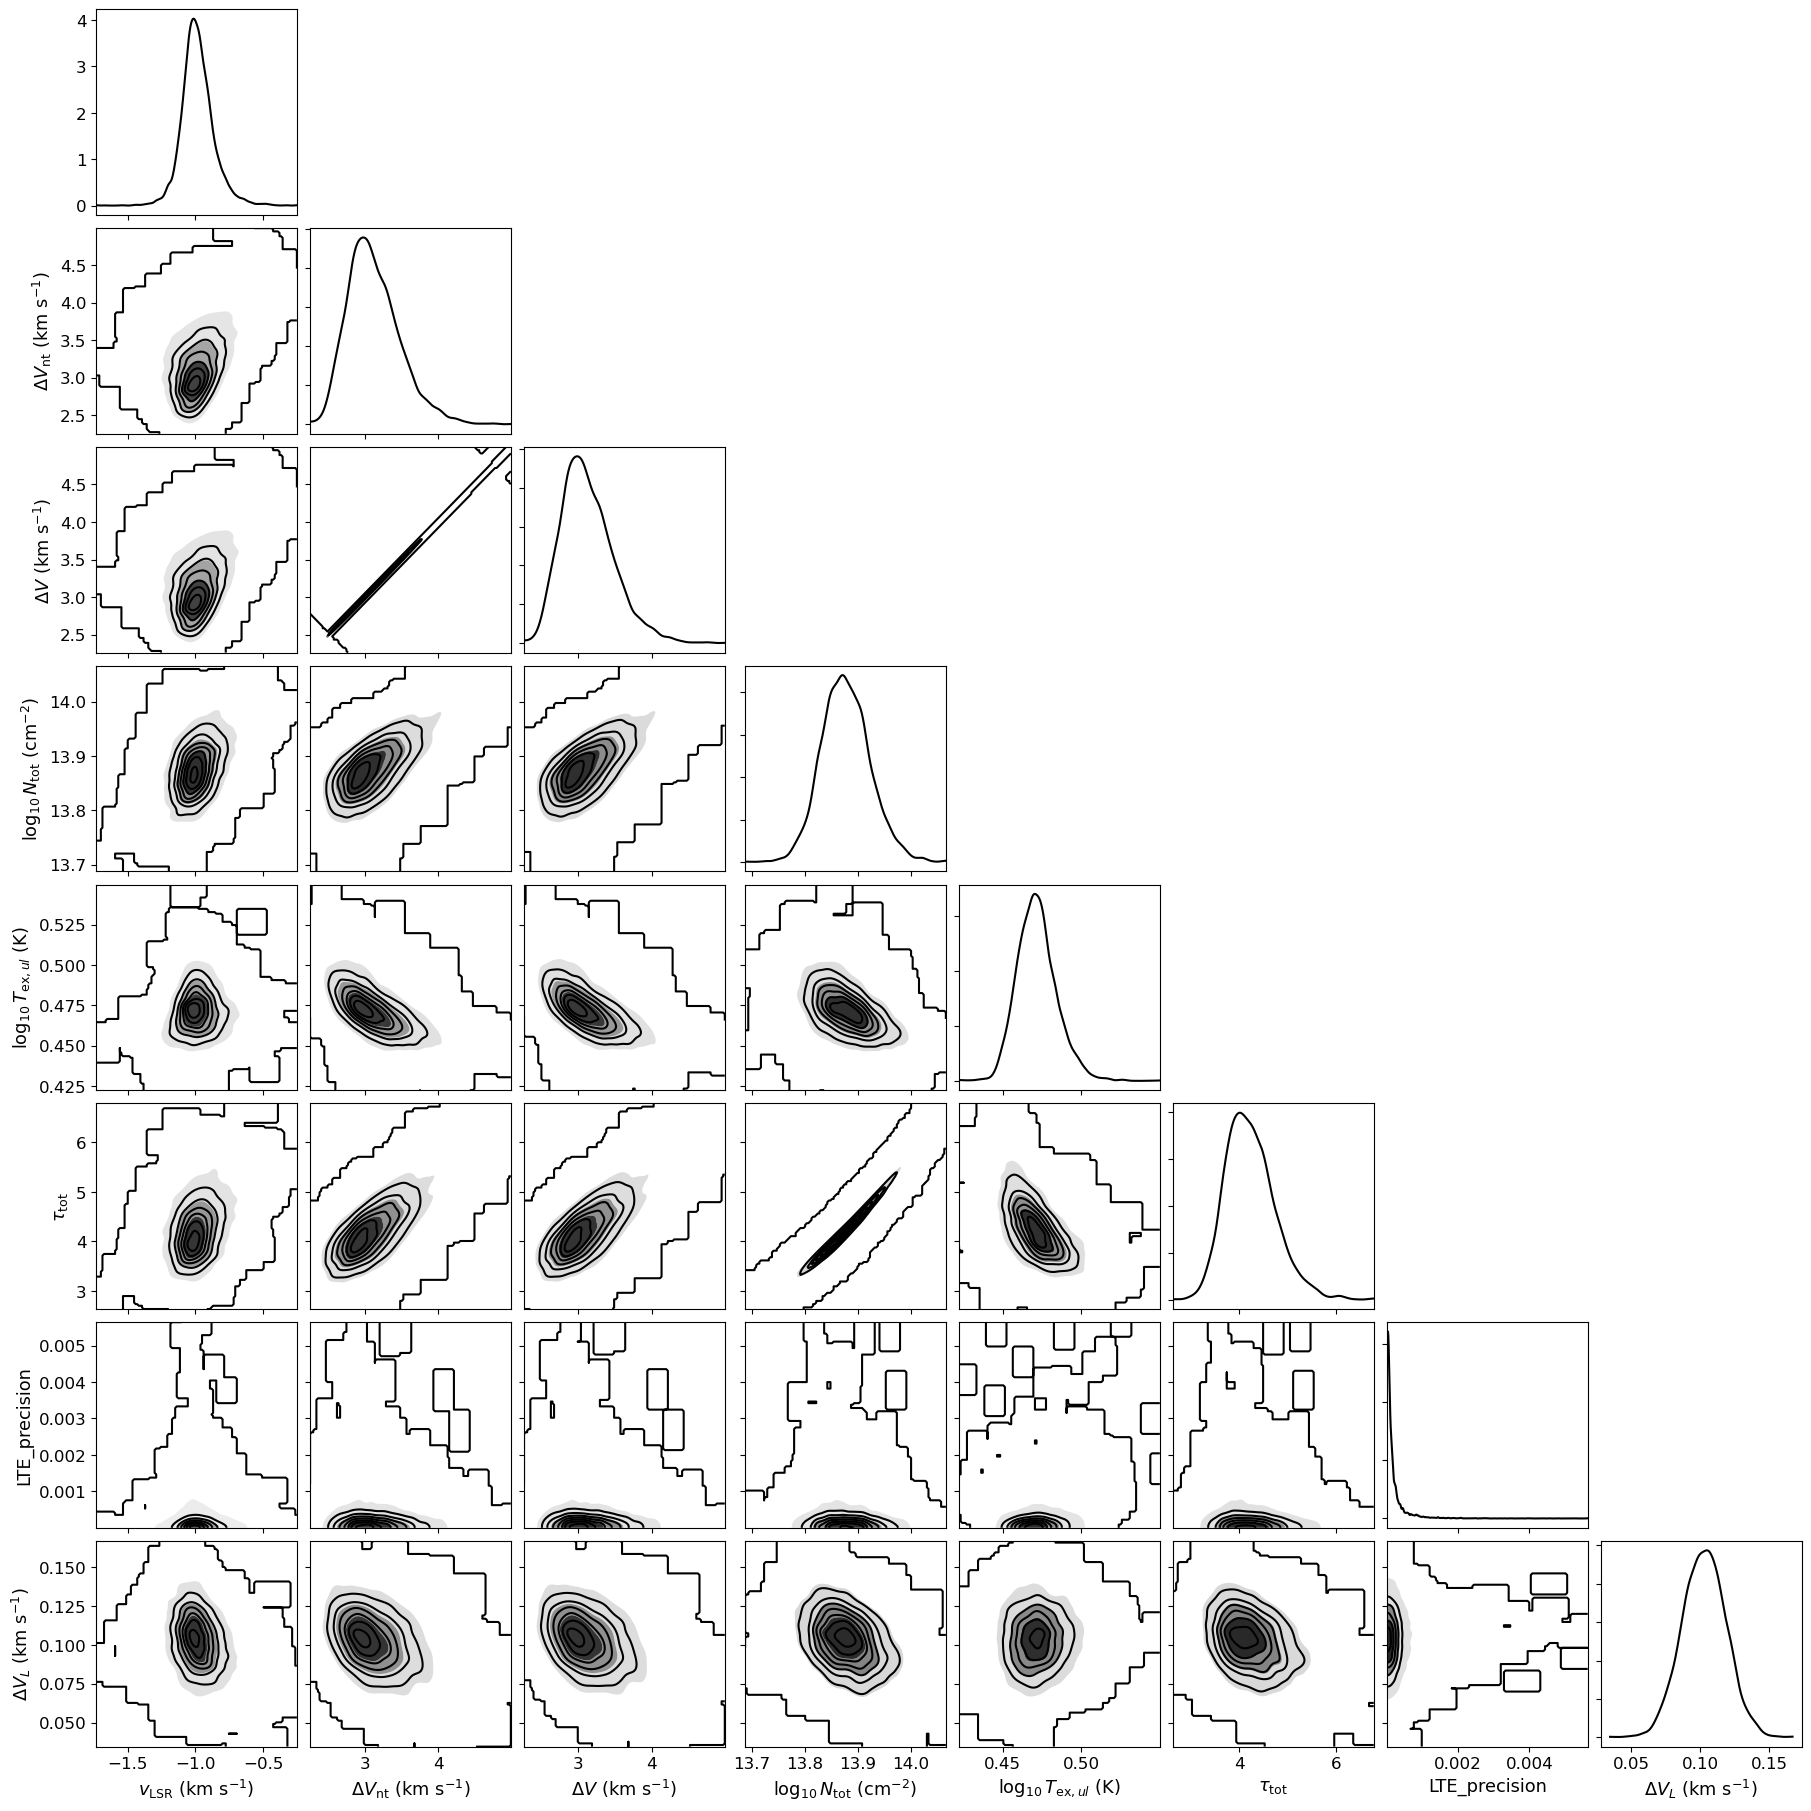

In [42]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + ["LTE_precision"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

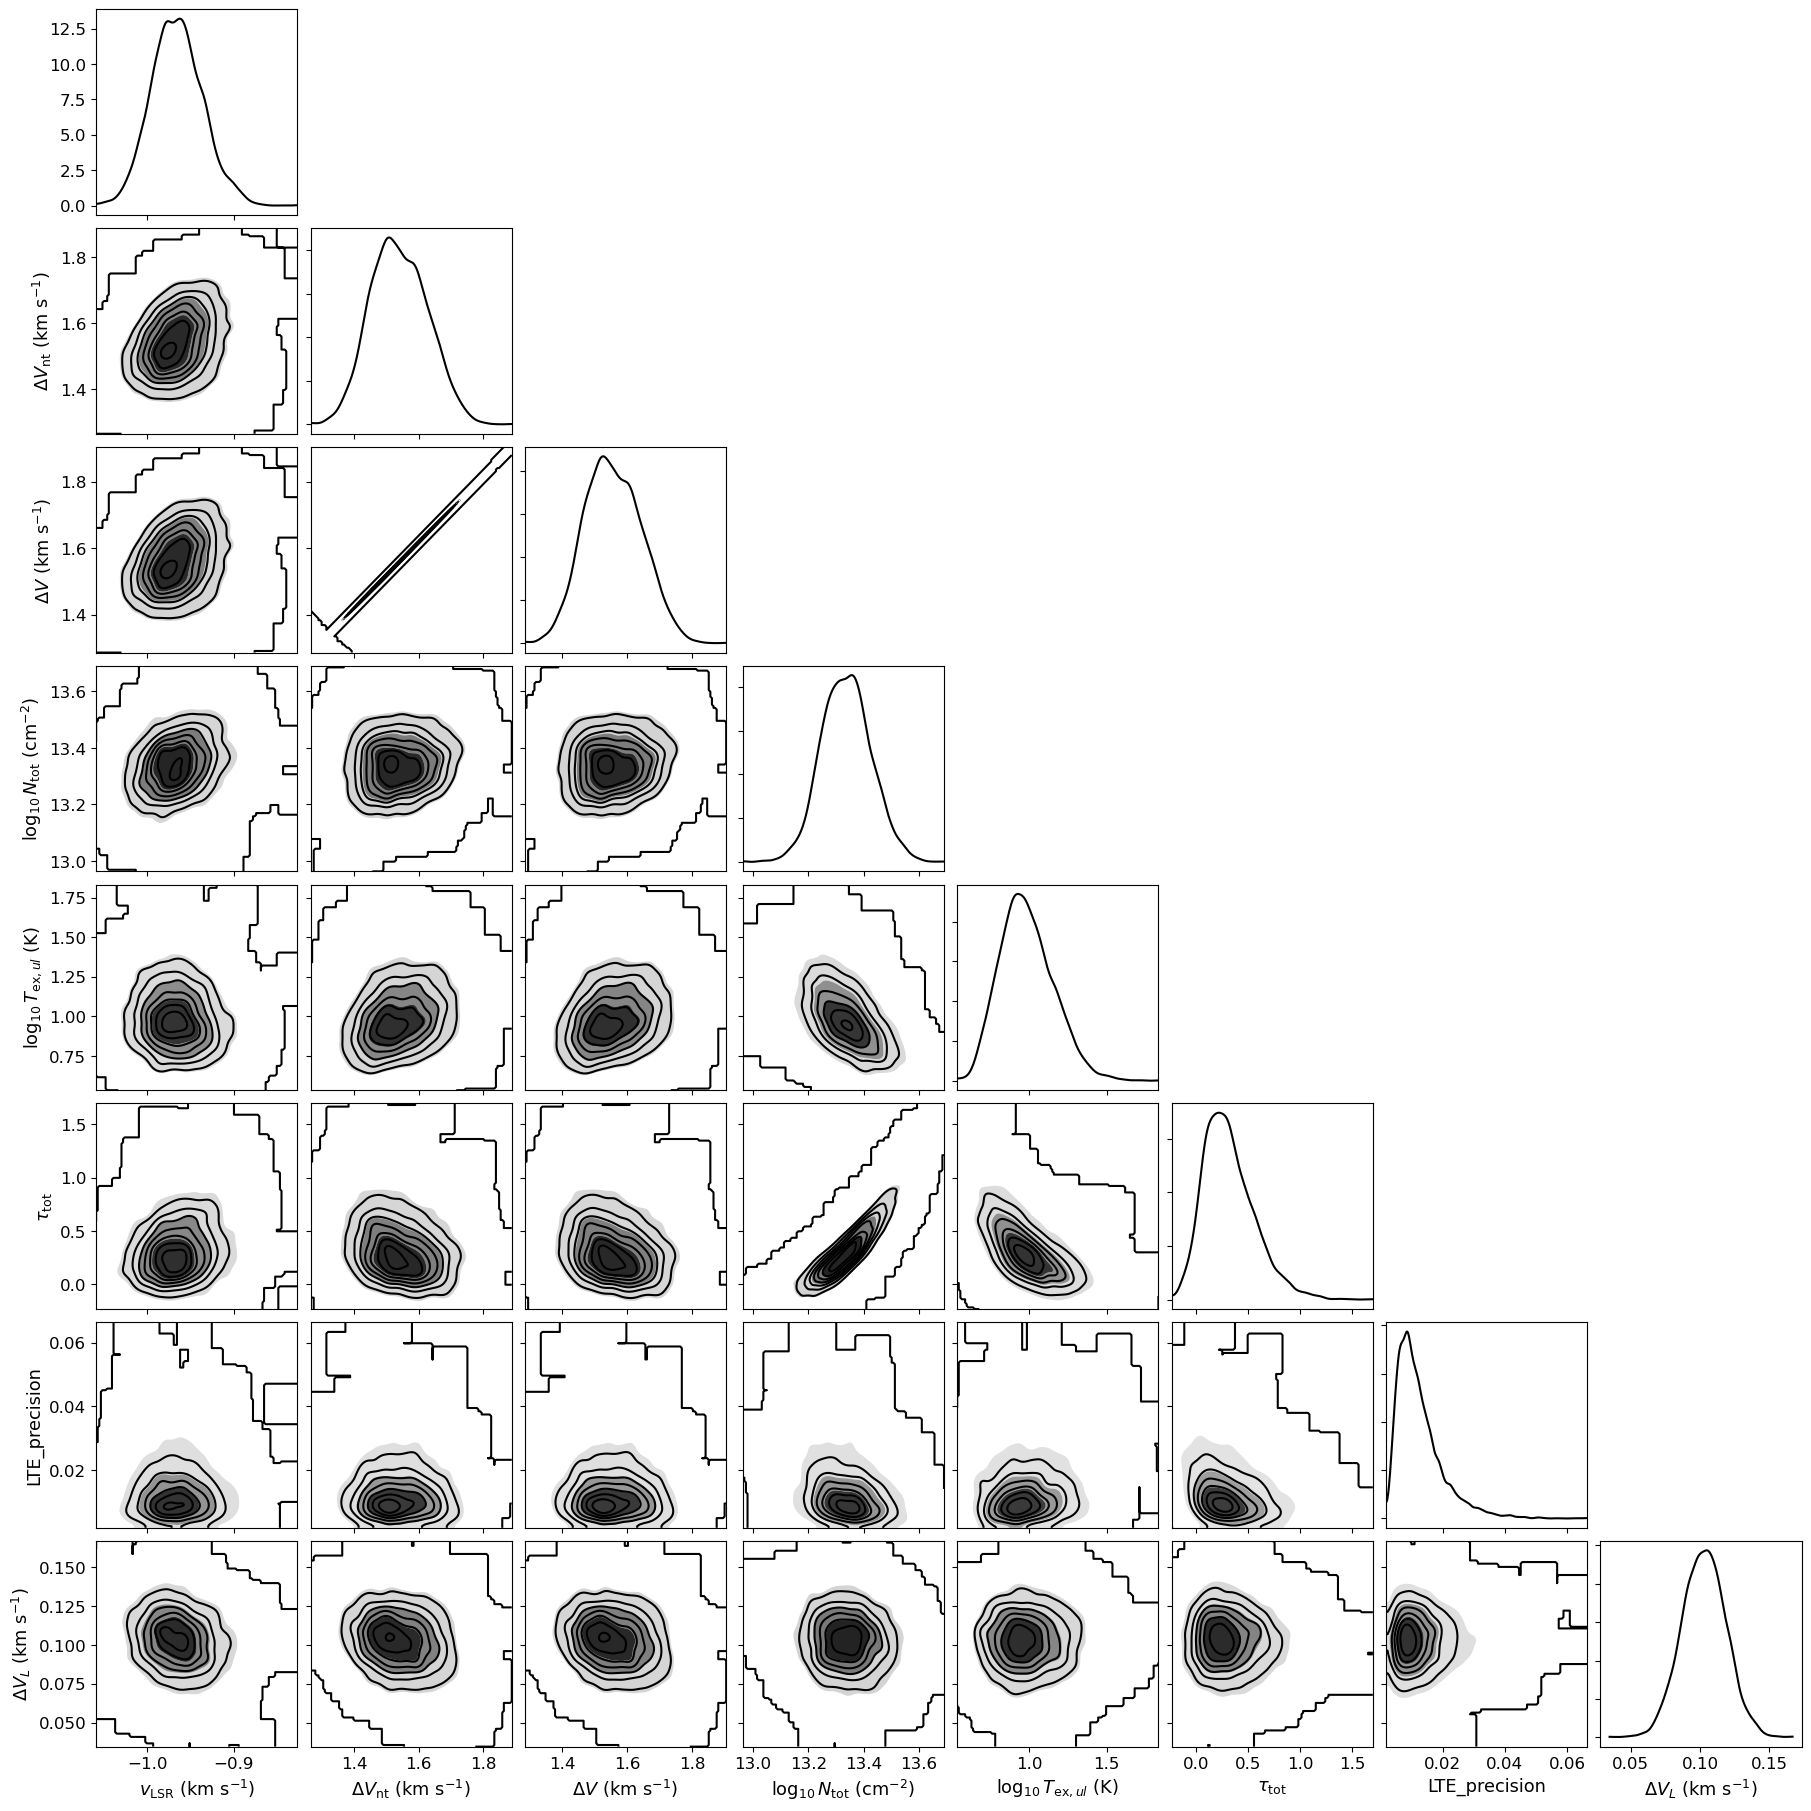

In [43]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + ["LTE_precision"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

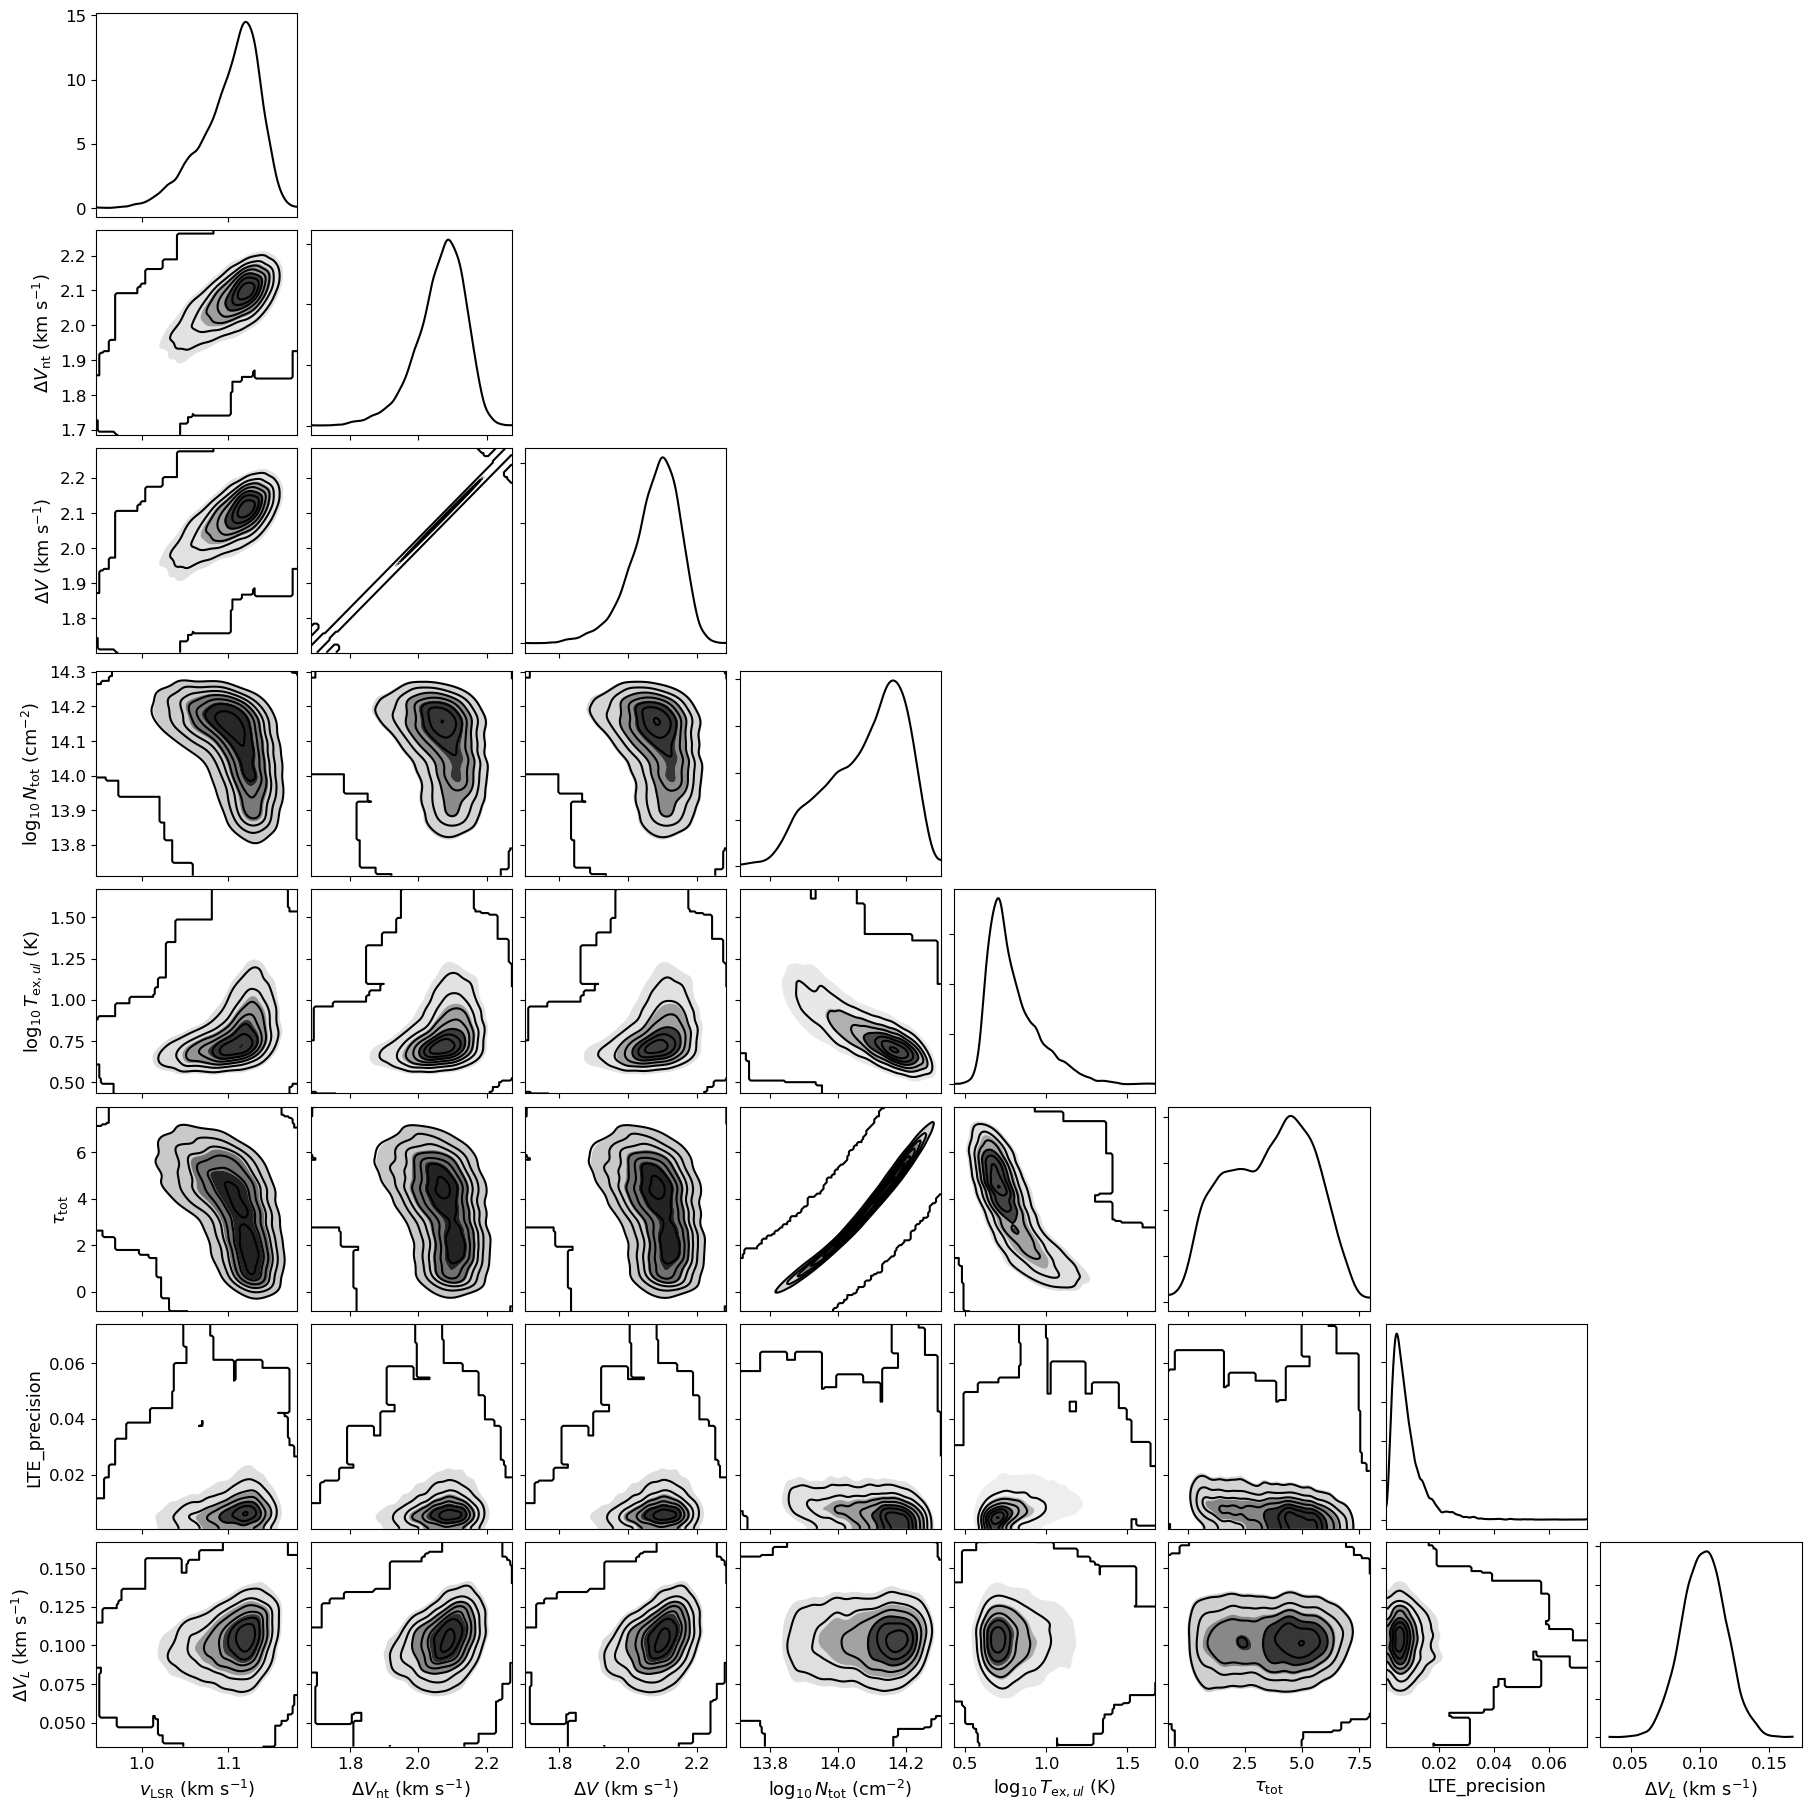

In [44]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=3), # samples
    var_names + ["LTE_precision"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

## Ratio Model

In [12]:
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# Initialize and define the model
n_clouds = 4 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.50, 0.25], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.6, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = True, # assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN]


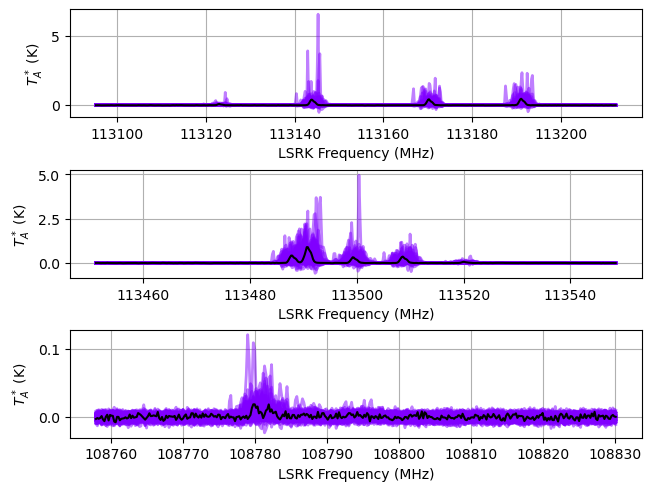

In [13]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [14]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 7800
Interrupted at 7,799 [7%]: Average Loss = 1.1695e+05


Output()

Runtime: 2.16 minutes


Sampling: [12CN-1, 12CN-2, 13CN]


Output()

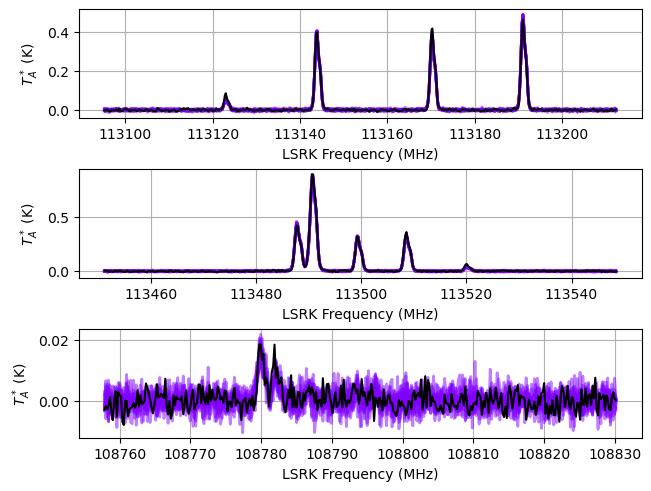

In [15]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7800
Interrupted at 7,799 [7%]: Average Loss = 1.1695e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C, log10_Tex_ul_norm, LTE_precision, weights_12CN]


Output()

In [ ]:
model.solve(kl_div_threshold=0.1)

In [ ]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics + model.hyper_deterministics + model.baseline_freeRVs)

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        #"transition_12CN", "transition_free_12CN", "transition_13CN", "transition_free_13CN",
        "state_l_12CN", "state_l_13CN"
    ]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [ ]:
import pickle
with open("/staging/twenger2/g211_trace.pkl", "wb") as f:
    pickle.dump(model.trace, f)

Note the degeneracy between the excitation temperature and 13CN column density.

In [ ]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        "transition_12CN", "transition_13CN", "transition_free_12CN",
        "state_l_12CN", "state_u_12CN", "state_l_13CN", "state_u_13CN"
    ]))
    and param not in ["fwhm_thermal_12CN", "fwhm_thermal_13CN"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + ["log10_inv_boltz_factor_free_12CN"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [ ]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + ["log10_inv_boltz_factor_free_12CN"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [ ]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + ["log10_inv_boltz_factor_free_12CN"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

These posterior distributions represent our knowledge about the physical conditions with only the assumption of CTEX for 13CN. The large uncertainties on the isotopic ratios reflect our lack of knowledge about the 13CN exitation temperature. We can sum over clouds and marginalize over the other parameters to quantify our inference about the isotopic ratio.

In [ ]:
N_12CN_tot = (10.0**model.trace.solution_0["log10_N_12CN"]).sum(dim="cloud")
N_13CN_tot = (10.0**model.trace.solution_0["log10_N_13CN"]).sum(dim="cloud")
ratio_12C_13C = N_12CN_tot/N_13CN_tot

print("12C/13C", ratio_12C_13C.mean(), ratio_12C_13C.std())

plt.hist(ratio_12C_13C.data.flatten(), bins=100, density=True)
plt.xlabel(r"$^{12}$/$^{13}$C")
plt.ylabel("Probability Density")

## Assumption about 13CN Excitation Temperature
We can further assume that the excitation conditions of 13CN are similar to 12CN. We could either condition the posteiror distribution of the previous model on this assumption, or we can factor it in to our model via a prior distribution. Here we specify the prior based on the 12CN excitation temperature distribution.

In [ ]:
# Column density weighted mean excitation temperature
N_12CN_weights = 10.0**model.trace.solution_0["log10_N_12CN"]
Tex_12CN = model.trace.solution_0["Tex_12CN"]
mean_Tex_12CN = (N_12CN_weights * Tex_12CN).sum(dim="cloud")/N_12CN_weights.sum(dim="cloud")

In [ ]:
plt.hist(np.log10(mean_Tex_12CN.data).flatten(), bins=100, density=True)
plt.xlabel(r"$\log_{10} T_{\rm ex, CN}$ (K)")
plt.ylabel("Probability Density")

print("log10 Tex 12CN", np.log10(mean_Tex_12CN).mean(), np.log10(mean_Tex_12CN).std())

In [ ]:
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0_12CN = [13.0, 0.25], # mean and width of log10 12CN ground state column density prior (cm-2)
    prior_log10_N0_13CN = [11.0, 0.25], # mean and width of log10 13CN ground state column density prior (cm-2)
    prior_log10_Tkin = None, # ignored for this fixed kinetic temperature model
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.556, 0.015], # mean and width of 13CN CTEX
    assume_CTEX_12CN = False, # do not assume 12CN CTEX
    assume_CTEX_13CN = True, # assume 13CN CTEX
    prior_log10_inv_boltz_factor = 5.0, # width of 12CN Boltzmann factor prior distribution
    fix_log10_Tkin = 1.5, # fix kinetic temperature 
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [ ]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [ ]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.05, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
model.solve(kl_div_threshold=0.1)

In [ ]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics + model.hyper_deterministics + model.baseline_freeRVs)

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set([
        #"transition_12CN", "transition_free_12CN", "transition_13CN", "transition_free_13CN",
        "state_l_12CN", "state_l_13CN"
    ]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)